# Post-processing for Lysis Front study

In [1]:
import black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=110,
    target_version=black.TargetVersion.PY310,
)

In [2]:
import datetime
import functools
import math
import os
import pickle
import re
import sys

sys.path.insert(1, os.path.abspath(".."))

from enum import IntEnum, unique

import scipy
from tqdm.notebook import trange, tqdm, tnrange

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from matplotlib.animation import FFMpegWriter, FuncAnimation
from matplotlib.colors import BoundaryNorm, ListedColormap

import lysis

pd.reset_option("display.precision")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

In [3]:
@unique
class MolStatus(IntEnum):
    UNBOUND = 0
    BOUND = 1
    MACRO_UNBOUND = 2
    MICRO_UNBOUND = 3

In [4]:
scenario_type = np.dtype(
    [
        ("descriptor", np.str_, 40),
        ("total_molecules", int),
        ("pore_size", float),  # in microns. Code requires cm
        ("fiber_diameter", float),  # in microns. Needs to be added to pore_size to get grid_node_distance
        ("binding_sites", int),
        ("cols", int),
        ("rows", int),
        ("empty_rows", int),
        ("forced_unbind", float),
    ]
)
mechanism_type = np.dtype([("descriptor", np.str_, 40), ("executable", np.str_, 40)])
run_type = np.dtype(
    [
        ("exp_code", np.str_, 15),
        ("scenario", np.str_, 40),
        ("mechanism", np.str_, 40),
        ("seed", np.int64),
        ("running_time", int),
        ("save_interval", int),
    ]
)
diameter_code = {
    72.7: "Q2",
    145.4: "Q4",
}

In [5]:
# seed sequence entropy: 334521664175407485272598290114063504226
scenarios = np.array(
    [
        ("TK-L_10000", 10_000, 1.0135, 145.4, 213, 87, 109, 22, 0.0729129),
        ("TK-L_555", 555, 1.0135, 145.4, 213, 87, 109, 22, 0.0729129),
        ("TN-D_5410", 5_410, 0.5495, 72.7, 427, 161, 202, 41, 0.0852),
        ("TN-D_300", 300, 0.5495, 72.7, 427, 161, 202, 41, 0.0852),
    ],
    dtype=scenario_type,
)
mechanisms = np.array(
    [
        ("Into and along - External", "macro_diffuse_into_and_along__external"),
    ],
    dtype=mechanism_type,
)

In [6]:
in_file_code = "_PLG2_tPA01_{input_code}.dat"
out_file_code = "_{scenario_code}"

# slope_tolerance = 1e-3
rng = np.random.default_rng(65463453)

In [7]:
group_code = "2024-01-26-10"
runs = np.array(
    [
        (group_code + "00", "TK-L_10000", "Into and along - External", 3_532_386_296, 0, 10),
        (group_code + "01", "TK-L_555", "Into and along - External", 1_799_319_593, 0, 10),
        (group_code + "02", "TN-D_5410", "Into and along - External", 3_756_429_037, 0, 10),
        (group_code + "03", "TN-D_300", "Into and along - External", 4_031_685_276, 0, 10),
    ],
    dtype=run_type,
)

In [8]:
# Get default parameters
e = lysis.Experiment(os.path.join("..", "..", "..", "data"), experiment_code="0000-00-00-0000")
e.initialize_macro_param()
df = pd.DataFrame([e.macro_params])

# Create empty DataFrame using the scenario names as rows and parameter names as columns
index = pd.Index(runs["scenario"], name="Scenario")
parameters_df = pd.DataFrame(index=index, columns=df.columns)
statistics = pd.MultiIndex.from_product(
    [
        [
            "Front Velocity (microns/min)",
            "Degradation rate (%/min)",
            "Lysis lag time (min)",
            "Time to full clot degradation (min)",
            "Percent of molecules that reached the back row",
            "First passage time (min)",
            "Total (Un)Binds",
            "Forced Unbinds (Microscale)",
            "Forced Unbinds (Macroscale)",
        ],
        ["Mean", "Standard Deviation"],
    ]
)
results = pd.DataFrame(index=index, columns=statistics)

In [9]:
formats = {
    "binding_rate": "{:.2f}",
    "pore_size": "{:1.5e}",
    "diffusion_coeff": "{:1.5e}",
    # 'binding_sites': "",
    "forced_unbind": "{:.3f}",
    "average_bind_time": "{:.2f}",
    "grid_node_distance": "{:.3f}",
    # 'cols', 'rows', 'fiber_rows', 'empty_rows', 'last_empty_edge',
    "full_row": "{:,}",
    "xz_row": "{:,}",
    "total_edges": "{:,}",
    "total_fibers": "{:,}",
    "total_molecules": "{:,}",
    "moving_probability": "{:.2f}",
    "microscale_runs": "{:,}",
    # 'total_trials',
    "total_time": "{:,.0f}",
    "time_step": "{:1.3e}",
    "total_time_steps": "{:,}",
    "seed": "{:,}",
    # 'save_interval',
    # 'number_of_saves',
}
cols_to_drop = [
    "state",
    "input_data",
    "output_data",
    "log_lvl",
    "duplicate_fortran",
    "processing_library",
    "macro_version",
]
# ,

In [10]:
scenario_grid = [
    ["TK-L_10000", "TK-L_555"],
    ["TN-D_5410", "TN-D_300"],
]
scenario_grid_T = [
    ["TK-L_10000", "TN-D_5410"],
    ["TK-L_555", "TN-D_300"],
]
groupings = [
    "Fixed Concentration - High",
    "Fixed Ratio",
    "Fixed Concentration - Low",
]
colors = {
    "TK-L_10000": "xkcd:red", 
    "TK-L_555": "xkcd:orange",
    "TN-D_5410": "xkcd:navy blue", 
    "TN-D_300": "xkcd:cyan",
}

In [11]:
index = pd.Index(runs["scenario"], name="Scenario")
degrade_percent_markers = [0.05, 0.2, 0.5, 0.8, 1]
columns = pd.MultiIndex.from_product(
    [[f"{int(i*100)}%" for i in degrade_percent_markers], range(10)], names=["Percent Degraded", "Simulation"]
)
degradation_time_df = pd.DataFrame(index=index, columns=columns)

# The definition of the lysis front
# The front is the first row with at least `front_def` proportion of fibers intact.
front_def = 0.2

degrade_slope_between_percent = [[0.2, 0.8], [0.2, 0.5], [0.5, 0.8]]
# degrade_slope_between_percent = [
#     [degrade_percent_markers.index(mark) for mark in slope] for slope in degrade_slope_between_percent
# ]
columns = pd.MultiIndex.from_product(
    [[f"{int(i[0]*100)}% to {int(i[1]*100)}%" for i in degrade_slope_between_percent], range(10)],
    names=["Degradation Interval", "Simulation"],
)
slopes_df = pd.DataFrame(index=index, columns=columns)
binds_df = pd.DataFrame(index=index, columns=pd.Index(range(10), name="Simulation"))

mol_time_statistics = [
    "Total Binds",
]
mol_time_df = pd.DataFrame(index=index, columns=mol_time_statistics)

pore_stat_df = pd.DataFrame(index=index, columns=[f"{int(i*100)}%" for i in degrade_percent_markers])

In [12]:
# For a light colormap of degraded fibers
colormap_f = plt.cm.cividis(np.arange(plt.cm.cividis.N))
colormap_f[:, 3] = 0.3
# For very light grey degraded fibers
colormap_f = ["xkcd:light grey"]

colormap_f = ListedColormap(colormap_f)
colormap_f.set_extremes(bad="xkcd:blue", under="white", over="xkcd:blue")
colormap_m = ListedColormap(["xkcd:green", "xkcd:cyan"])
bounds = [0, 0.5, 1]
norm_m = BoundaryNorm(bounds, colormap_m.N)

angle = (1 / 2 - 1 / 8) * math.pi
radius = 0.5

### Utility Functions

In [13]:
def load_fortran_files(exp, file_code):
    n_save = np.asarray(
        [
            np.fromfile(
                os.path.join(e.os_path, f"{sim:02}", f"Nsave{file_code[:-4]}_{sim:02}{file_code[-4:]}"),
                dtype=np.int32,
            )[0]
            for sim in range(e.macro_params.total_trials)
        ]
    )
    n_save += 1
    n_save

    tsave = [
        np.fromfile(os.path.join(e.os_path, f"{sim:02}", f"tsave{file_code[:-4]}_{sim:02}{file_code[-4:]}"))
        for sim in range(e.macro_params.total_trials)
    ]
    tmax = max([np.max(arr) for arr in tsave])

    mfpt = np.asarray(
        [
            np.fromfile(
                os.path.join(e.os_path, f"{sim:02}", f"mfpt{file_code[:-4]}_{sim:02}{file_code[-4:]}")
            )
            for sim in range(e.macro_params.total_trials)
        ]
    )

    mol_location = []
    mol_status = []
    mapped_deg = []
    for sim in range(e.macro_params.total_trials):
        raw_mol_location = np.fromfile(
            os.path.join(e.os_path, f"{sim:02}", f"m_loc{file_code[:-4]}_{sim:02}{file_code[-4:]}"),
            dtype=np.int32,
        )
        mol_location.append(raw_mol_location.reshape(n_save[sim], e.macro_params.total_molecules) - 1)

        raw_mol_status = np.fromfile(
            os.path.join(e.os_path, f"{sim:02}", f"m_bound{file_code[:-4]}_{sim:02}{file_code[-4:]}"),
            dtype=np.int32,
        )
        raw_mol_status = raw_mol_status.astype(np.bool_)
        mol_status.append(raw_mol_status.reshape(n_save[sim], e.macro_params.total_molecules))

        raw_deg = np.fromfile(
            os.path.join(e.os_path, f"{sim:02}", f"f_deg_time{file_code[:-4]}_{sim:02}{file_code[-4:]}")
        )
        # raw_mapped_deg[raw_deg == 0] = tmax + e.macro_params.save_interval  # float('inf') #
        mapped_deg.append(raw_deg.reshape(n_save[sim], e.macro_params.total_edges))

    return n_save, mapped_deg, tsave, mfpt, mol_location, mol_status


def ensure_results_match(exp, file_code, old_code):
    e_old = lysis.util.Experiment(
        os.path.join("..", "..", "..", "data"), experiment_code=old_code + exp.experiment_code[-2:]
    )
    e_old.read_file()
    n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)
    n_save_old, deg_old, tsave_old, mfpt_old, mol_location_old, mol_status_old = load_fortran_files(
        e_old, file_code
    )
    if np.count_nonzero(n_save != n_save_old) > 0:
        return False
    for i in range(e.macro_params.total_trials):
        if np.count_nonzero(deg[i] != deg_old[i]) > 0:
            return False
        if np.count_nonzero(tsave[i] != tsave_old[i]) > 0:
            return False
        if np.count_nonzero(mfpt[i] != mfpt_old[i]) > 0:
            return False
        if np.count_nonzero(mol_location[i] != mol_location_old[i]) > 0:
            return False
        if np.count_nonzero(mol_status[i] != mol_status_old[i]) > 0:
            return False
    return True

### Standard Parameter Functions & Plots

In [14]:
def find_degraded_fraction(exp, deg, tsave):
    degraded_fraction = []
    for sim in range(exp.macro_params.total_trials):
        run_degraded_fraction = np.empty(deg[sim].shape[0], dtype=np.float_)
        for t in range(deg[sim].shape[0]):
            run_degraded_fraction[t] = np.count_nonzero(deg[sim][t] <= tsave[sim][t])
        run_degraded_fraction -= exp.macro_params.empty_rows * exp.macro_params.full_row
        degraded_fraction.append(run_degraded_fraction / exp.macro_params.total_fibers)
    return degraded_fraction


def find_degradation_marker_frames(exp, degraded_fraction, degrade_percent_markers):
    degrade_marker_frames = np.empty((len(degraded_fraction), len(degrade_percent_markers)), dtype=np.int_)
    for sim in range(len(degraded_fraction)):
        for marker in range(len(degrade_percent_markers)):
            degrade_marker_frames[sim, marker] = np.argmax(
                degraded_fraction[sim] >= degrade_percent_markers[marker]
            )
    return degrade_marker_frames


# Changed back to min
def find_degradation_marker_times(exp, degrade_marker_frames, tsave):
    degradation_marker_times = np.empty(
        (len(degrade_marker_frames), len(degrade_marker_frames[0])), dtype=np.float_
    )
    for sim in range(len(degrade_marker_frames)):
        degradation_marker_times[sim] = tsave[sim][degrade_marker_frames[sim]]
    return degradation_marker_times / 60


def degradation_rates(exp, degrade_marker_frames, degraded_fraction, tsave):
    degradation_rates = np.empty(
        (exp.macro_params.total_trials, len(degrade_slope_between_percent)), dtype=np.float_
    )
    for sim in range(exp.macro_params.total_trials):
        for slope in range(len(degrade_slope_between_percent)):
            start_frame = degrade_marker_frames[
                sim, degrade_percent_markers.index(degrade_slope_between_percent[slope][0])
            ]
            end_frame = degrade_marker_frames[
                sim, degrade_percent_markers.index(degrade_slope_between_percent[slope][1])
            ]
            delta_y = degraded_fraction[sim][end_frame] - degraded_fraction[sim][start_frame]
            delta_x = tsave[sim][end_frame] - tsave[sim][start_frame]
            degradation_rates[sim, slope] = delta_y / delta_x * 60  # * 100
    return degradation_rates


def save_degrade_fraction_table(exp, file_code, degraded_fraction, tsave):
    max_time = 0
    max_time_idx = None
    for i in range(len(tsave)):
        if len(tsave[i]) > max_time:
            max_time = len(tsave[i])
            max_time_idx = i
    index = pd.Index(range(10), name="Simulation")
    columns = pd.Index((tsave[max_time_idx] / 60), name="Simulation Time Elapsed (min)")
    pd.DataFrame(degraded_fraction, index=index, columns=columns).fillna(1).to_csv(
        os.path.join(exp.os_path, "deg_fraction_at_time_in_min" + file_code[:-4] + ".csv")
    )


# Must match units
# Is expecting degradation rates in frac/min
def plot_degradation_percent(exp, degraded_fraction, tsave, degrade_marker_frames, degradation_rates):
    start_stop = [
        [degrade_percent_markers.index(mark) for mark in slope] for slope in degrade_slope_between_percent
    ]
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlim(0, (max([np.max(deg_run[-1, :]) for deg_run in deg]) // 60) + 1)
    ax.set_ylim(-0.1, 1.1)
    for sim in range(exp.macro_params.total_trials):
        plt.plot(tsave[sim] / 60, degraded_fraction[sim])
        for slope in range(len(start_stop)):
            start_frame = degrade_marker_frames[sim, start_stop[slope][0]]
            end_frame = degrade_marker_frames[sim, start_stop[slope][1]]
            lin_func = (
                lambda x: degradation_rates[sim, slope] * (x - tsave[sim][start_frame] / 60)
                + degraded_fraction[sim][start_frame]
            )
            plt.plot(
                tsave[sim][start_frame:end_frame] / 60,
                lin_func(tsave[sim][start_frame:end_frame] / 60),
                color="b",
                alpha=0.5,
                zorder=0.1,
            )
    fig.savefig(os.path.join(exp.os_path, "deg_rate" + file_code[:-4] + ".png"), bbox_inches="tight")
    plt.close()


def calculate_time_row_exposed(exp, deg):
    exposed_time = np.empty(
        (exp.macro_params.total_trials, exp.macro_params.rows - 1, exp.macro_params.cols), dtype=np.float_
    )
    for run in range(exp.macro_params.total_trials):
        for j in range(exp.macro_params.cols):
            for i in range(exp.macro_params.rows - 1):
                if i == 0:
                    exposed_time[run, i, j] = 0
                else:
                    k = lysis.to_fortran_edge_index(i, j, exp.macro_params.rows, exp.macro_params.cols)
                    exposed_time[run, i, j] = max(exposed_time[run, i - 1, j], deg[run][-1, k])
    # exposed_time = 10* np.ceil(exposed_time / 10)
    return exposed_time / 60


def find_degradation_fronts(exp, exposed_time, y_distance, tsave):
    deg_fronts = []
    for r in range(exp.macro_params.total_trials):
        run_deg_fronts = []
        for j in range(exp.macro_params.cols):
            col_deg_front = []
            for i in range(1, exp.macro_params.rows - 1):
                if exposed_time[r, i - 1, j] < exposed_time[r, i, j] < tsave[r][-1] + 1:
                    col_deg_front.append([exposed_time[r, i, j], y_distance[i]])
            run_deg_fronts.append(np.array(col_deg_front).T)
        deg_fronts.append(run_deg_fronts)
    return deg_fronts


# TODO(bpaynter): Change this later to do mean and std of all columns across all runs
def mean_front_velocity(exp, deg_fronts):
    run_mean_velocity = np.empty(exp.macro_params.total_trials, dtype=np.float_)
    run_std_velocity = np.empty(exp.macro_params.total_trials, dtype=np.float_)
    for run in range(exp.macro_params.total_trials):
        front_velocity = np.empty(exp.macro_params.cols, dtype=np.float_)
        for j in range(exp.macro_params.cols):
            b, m = np.polynomial.polynomial.polyfit(deg_fronts[run][j][0], deg_fronts[run][j][1], 1)
            front_velocity[j] = m
        run_mean_velocity[run] = np.mean(front_velocity)
        run_std_velocity[run] = np.std(front_velocity)
    return np.mean(run_mean_velocity), np.mean(run_std_velocity)


def plot_front_degradation(exp, file_code, deg_fronts, deg):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_on()
    ax.set_xlim(0, (max([np.max(deg_run[-1, :]) for deg_run in deg]) // 60) + 1)
    ax.set_ylim(
        (exp.macro_params.empty_rows - 1) * e.macro_params.grid_node_distance,
        (exp.macro_params.rows - 1) * exp.macro_params.grid_node_distance,
    )
    for run in range(exp.macro_params.total_trials):
        for j in range(exp.macro_params.cols):
            plt.plot(deg_fronts[run][j][0], deg_fronts[run][j][1], linewidth=1)
    fig.savefig(os.path.join(exp.os_path, "deg_fronts" + file_code[:-4] + ".png"), bbox_inches="tight")
    plt.close()


def mean_degradation_rate(exp, degraded_fraction, tsave):
    degradation_rate = np.empty(exp.macro_params.total_trials, dtype=np.float_)
    offset = np.empty(exp.macro_params.total_trials, dtype=np.float_)
    deg_start_time = np.empty(exp.macro_params.total_trials, dtype=np.float_)
    for r in range(exp.macro_params.total_trials):
        slope = np.empty(degraded_fraction[r].shape[0], dtype=np.float_)
        slope[0] = degraded_fraction[r][0]
        for t in range(1, degraded_fraction[r].shape[0]):
            slope[t] = degraded_fraction[r][t] - degraded_fraction[r][t - 1]
        degradation_happening = slope > slope.max() / 2
        s = np.argmax(degradation_happening)
        b, m = np.polynomial.polynomial.polyfit(
            tsave[r][degradation_happening] / 60, degraded_fraction[r][degradation_happening], 1
        )
        degradation_rate[r] = m
        offset[r] = b
        deg_start_time[r] = tsave[r][s] / 60
    return degradation_rate, offset, deg_start_time


def find_row_deg_fraction(exp, deg, tsave):
    row_deg = []
    for s in range(exp.macro_params.total_trials):
        row_deg.append(
            np.count_nonzero(
                (deg[s] > tsave[s].reshape(tsave[s].size, 1))[
                    :, exp.macro_params.empty_rows * exp.macro_params.full_row : -exp.macro_params.xz_row
                ].reshape((deg[s].shape[0], exp.macro_params.fiber_rows - 1, exp.macro_params.full_row)),
                axis=2,
            )
            / exp.macro_params.full_row
        )
    return row_deg


def find_front(exp, row_deg):
    return [np.argmax(sim_row_deg >= front_def, axis=1) for sim_row_deg in row_deg]


def get_unbind_amounts(exp, file_code, mech):
    macro_unbind_pattern = re.compile(r"countmacrounbd=\s*(\d+)")
    micro_unbind_pattern = re.compile(r"countmicrounbd=\s*(\d+)")
    log_text = ""
    for sim in range(e.macro_params.total_trials):
        log_file_name = os.path.join(e.os_path, f"{sim:02}", f"macro{file_code[:-4]}_{sim:02}.txt")
        with open(log_file_name, "r") as file:
            log_text += file.read()
    macro_unbinds = re.findall(macro_unbind_pattern, log_text)
    micro_unbinds = re.findall(micro_unbind_pattern, log_text)
    return np.array(macro_unbinds, dtype=int), np.array(micro_unbinds, dtype=int)


def get_processing_time(exp, file_code, mech):
    processing_time_pattern = re.compile(r"Processing time:\s*(\d+.\d+)\s*sec")
    log_text = ""
    for sim in range(e.macro_params.total_trials):
        log_file_name = os.path.join(e.os_path, f"{sim:02}", f"macro{file_code[:-4]}_{sim:02}.txt")
        with open(log_file_name, "r") as file:
            log_text += file.read()
    processing_time = re.findall(processing_time_pattern, log_text)
    return np.array(processing_time, dtype=float)


def get_total_binds(exp, file_code, mech):
    total_binds_pattern = re.compile(r"Total Binds:\s*(\d+.\d+)\s*")
    log_text = ""
    for sim in range(e.macro_params.total_trials):
        log_file_name = os.path.join(e.os_path, f"{sim:02}", f"macro{file_code[:-4]}_{sim:02}.txt")
        with open(log_file_name, "r") as file:
            log_text += file.read()
    total_binds = re.findall(total_binds_pattern, log_text)
    return np.array(total_binds, dtype=int)

### Grid Plot Functions

In [15]:
def plot_coords(i, j):
    x = j
    y = -i
    if j % 3 == 0:
        return x / 3.0, y - 0.5
    if j % 3 == 1:
        return (x - 1) / 3.0, y
    if j % 3 == 2:
        return (x - 2) / 3.0 + 0.5, y


def get_edge_index(exp):
    edge_index = np.empty(exp.macro_params.total_edges, dtype=tuple)
    for k in range(exp.macro_params.total_edges):
        edge_index[k] = lysis.from_fortran_edge_index(k, exp.macro_params.rows, exp.macro_params.cols)
    return edge_index


def get_rev_edge_index(exp):
    rev_edge_index = np.full((exp.macro_params.rows, exp.macro_params.full_row), -1, dtype=int)
    for k in range(exp.macro_params.total_edges):
        rev_edge_index[lysis.from_fortran_edge_index(k, exp.macro_params.rows, exp.macro_params.cols)] = k
    return rev_edge_index


def animation_data(exp, edge_index, mol_location):
    x_f = np.empty(exp.macro_params.total_edges, dtype=float)
    y_f = np.empty(exp.macro_params.total_edges, dtype=float)
    for k in range(exp.macro_params.total_edges):
        i, j = edge_index[k]
        x_f[k], y_f[k] = plot_coords(i, j)
    d_x = (rng.random(size=exp.macro_params.total_molecules) - 0.5) / 2.5
    d_y = (rng.random(size=exp.macro_params.total_molecules) - 0.5) / 2.5
    x_m = []
    y_m = []
    for r in range(exp.macro_params.total_trials):
        x = np.empty((n_save[r], exp.macro_params.total_molecules), dtype=np.float_)
        y = np.empty((n_save[r], exp.macro_params.total_molecules), dtype=np.float_)
        for t in range(n_save[r]):
            for k in range(exp.macro_params.total_molecules):
                i, j = edge_index[mol_location[r][t, k]]
                x[t, k], y[t, k] = plot_coords(i, j)
            x[t] += d_x
            y[t] += d_y
        x_m.append(x)
        y_m.append(y)
    return x_f, y_f, x_m, y_m


def create_animation(exp, file_code, edge_index, deg, mol_status, tsave, x_f, y_f, x_m, y_m, fronts=None):
    for sim in range(1):
        fig = plt.figure(figsize=(exp.macro_params.cols / 10, exp.macro_params.rows / 10), dpi=100)
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_axis_off()
        vmin = 0
        vmax = exp.macro_params.cols - 1

        ydiff = exp.macro_params.rows - exp.macro_params.cols

        ax.set_xlim(vmin - 0.25, vmax + 0.25)
        ax.set_ylim(-vmax - ydiff - 0.25, -vmin + 0.25)
        ax.set_aspect("equal")
        fig.canvas.draw()
        title = ax.annotate(
            f"Time elapsed: {str(datetime.timedelta(seconds=tsave[sim][0])).split('.')[0]}",
            (0, 0),
            zorder=100,
            va="top",
        )
        s = (ax.get_window_extent().width / (vmax - vmin + 0.5) * 72 / (2 * fig.dpi)) ** 2
        scatt_f = ax.scatter(
            x_f,
            y_f,
            s=s,
            marker="s",
            linewidths=0,
            c=deg[sim][0],
            cmap=colormap_f,
            vmin=exp.macro_params.time_step,
            vmax=exp.macro_params.time_step,
        )
        scatt_m = ax.scatter(
            x_m[sim][0],
            y_m[sim][0],
            s=s / 2.5,
            marker="o",
            linewidths=0,
            c=mol_status[sim][0],
            cmap=colormap_m,
            norm=norm_m,
        )
        if not fronts is None:
            front_line = ax.axhline(
                y=y_f[(exp.macro_params.empty_rows + fronts[sim][0]) * exp.macro_params.full_row],
                color="xkcd:hot pink",
            )

        def update(frame_number):
            scatt_f.set_array(deg[sim][frame_number])
            if tsave[sim][frame_number] == 0:
                scatt_f.set_clim(vmin=exp.macro_params.time_step, vmax=exp.macro_params.time_step)
            else:
                scatt_f.set_clim(vmin=exp.macro_params.time_step, vmax=tsave[sim][frame_number])
            scatt_m.set_array(mol_status[sim][frame_number])
            scatt_m.set_offsets(np.append((x_m[sim][frame_number],), (y_m[sim][frame_number],), axis=0).T)
            if not fronts is None:
                y = y_f[(exp.macro_params.empty_rows + fronts[sim][frame_number]) * exp.macro_params.full_row]
                front_line.set_ydata([y, y])
            title.set_text(
                f"Time elapsed: {str(datetime.timedelta(seconds=tsave[sim][frame_number])).split('.')[0]}"
            )

        animation = FuncAnimation(fig, update, frames=np.arange(n_save[sim]), interval=200)

        FFwriter = FFMpegWriter(fps=10)
        animation.save(
            os.path.join(e.os_path, f"{sim:02}", f"combined_animation_{sim:02}" + file_code[:-4] + ".mp4"),
            writer=FFwriter,
        )
        plt.close()


def create_animation_stills(
    exp,
    file_code,
    degrade_marker_frames,
    edge_index,
    deg,
    mol_status,
    tsave,
    x_f,
    y_f,
    x_m,
    y_m,
    fronts=None,
):
    for sim in range(1):
        for i, frame in enumerate(degrade_marker_frames[sim]):
            fig = plt.figure(figsize=(exp.macro_params.cols / 10, exp.macro_params.rows / 10), dpi=100)
            ax = fig.add_axes([0, 0, 1, 1])
            ax.set_axis_off()
            vmin = 0
            vmax = exp.macro_params.cols - 1

            ydiff = exp.macro_params.rows - exp.macro_params.cols

            ax.set_xlim(vmin - 0.25, vmax + 0.25)
            ax.set_ylim(-vmax - ydiff - 0.25, -vmin + 0.25)
            ax.set_aspect("equal")
            fig.canvas.draw()
            title = ax.annotate(
                f"Simulation time elapsed: {str(datetime.timedelta(seconds=tsave[sim][frame])).split('.')[0]}",
                (0, 0),
                zorder=100,
                va="top",
            )
            s = (ax.get_window_extent().width / (vmax - vmin + 0.5) * 72 / (2 * fig.dpi)) ** 2
            scatt_f = ax.scatter(
                x_f,
                y_f,
                s=s,
                marker="s",
                linewidths=0,
                c=deg[sim][frame],
                cmap=colormap_f,
                vmin=exp.macro_params.time_step,
                vmax=tsave[sim][frame],
            )
            scatt_m = ax.scatter(
                x_m[sim][frame],
                y_m[sim][frame],
                s=s / 2.5,
                marker="o",
                linewidths=0,
                c=mol_status[sim][frame],
                cmap=colormap_m,
                norm=norm_m,
            )
            if not fronts is None:
                front_line = ax.axhline(
                    y=y_f[(exp.macro_params.empty_rows + fronts[sim][frame]) * exp.macro_params.full_row],
                    color="xkcd:hot pink",
                )

            fig.savefig(
                os.path.join(
                    e.os_path,
                    f"{sim:02}",
                    f"experiment_state_plot_r{sim:02}_{degrade_percent_markers[i]:.2f}"
                    + file_code[:-4]
                    + ".png",
                ),
                bbox_inches="tight",
            )
            plt.close()


def fiber_end_coords(i, j):
    x1 = j // 3
    y1 = i
    if j % 3 == 0:
        x2 = x1
        y2 = y1 + 1
    elif j % 3 == 1:
        x2 = x1 + radius * math.cos(angle)
        y2 = y1 - radius * math.sin(angle)
        x1 = x1 - radius * math.cos(angle)
        y1 = y1 + radius * math.sin(angle)
    elif j % 3 == 2:
        x2 = x1 + 1
        y2 = y1
    return x1, y1, x2, y2


def grid_data(exp, edge_index):
    x1_f = np.empty(exp.macro_params.total_edges, dtype=float)
    y1_f = np.empty(exp.macro_params.total_edges, dtype=float)
    x2_f = np.empty(exp.macro_params.total_edges, dtype=float)
    y2_f = np.empty(exp.macro_params.total_edges, dtype=float)
    for k in range(exp.macro_params.total_edges):
        i, j = edge_index[k]
        x1_f[k], y1_f[k], x2_f[k], y2_f[k] = fiber_end_coords(i, j)
    return x1_f, y1_f, x2_f, y2_f


def create_fiber_grid_plot(
    exp, file_code, edge_index, degrade_marker_frames, deg, tsave, x1_f, y1_f, x2_f, y2_f, fronts=None,
):
    image_scale = (
        exp.macro_params.grid_node_distance
        / 72
        / (exp.macro_params.grid_node_distance - 10_000 * exp.macro_params.pore_size)
    )
    for sim in range(1):
        for idx, frame in enumerate(degrade_marker_frames[sim]):
            fig = plt.figure(
                figsize=(exp.macro_params.cols * image_scale, exp.macro_params.rows * image_scale), dpi=72
            )
            ax = fig.add_axes([0, 0, 1, 1])
            ax.set_axis_off()
            vmin = 0
            vmax = e.macro_params.cols - 1

            ydiff = e.macro_params.rows - e.macro_params.cols

            ax.set_xlim(vmin - 0.25, vmax + 0.25)
            ax.set_ylim(-vmax - ydiff - 0.25, -vmin + 0.25)
            ax.set_aspect("equal")
            fig.canvas.draw()

            # grid_width = 1000 * e.macro_params.grid_node_distance * (e.macro_params.cols - 1)  # in nanometers
            # figure_width = fig.get_figwidth() * fig.dpi  # in points (should be pixels too)
            # point_length = grid_width / figure_width  # in nanometers per point

            # fiber_thickness = (
            #     1000 * (e.macro_params.grid_node_distance - 10_000 * e.macro_params.pore_size) / point_length
            # )

            for k in range(e.macro_params.total_edges):
                i, j = edge_index[k]
                if j % 3 != 1:
                    if deg[sim][frame][k] > tsave[sim][frame]:
                        plt.plot(
                            [x1_f[k], x2_f[k]],
                            [-y1_f[k], -y2_f[k]],
                            color="black",
                            marker=None,
                            linewidth=1,
                        )
            if not fronts is None:
                front_line = ax.axhline(
                    y=-y1_f[(exp.macro_params.empty_rows + fronts[sim][frame]) * exp.macro_params.full_row],
                    color="xkcd:hot pink",
                )
            fig.savefig(
                os.path.join(
                    e.os_path,
                    f"{sim:02}",
                    f"fiber_grid_plot{file_code[:-4]}_r{sim:02}_{1-(np.count_nonzero(deg[sim][frame] > tsave[sim][frame])/exp.macro_params.total_fibers):.2f}.png",
                ),
                bbox_inches="tight",
            )
            plt.close()

### Binding/Moving Analysis Functions

In [16]:
def check_row_interval(row, start, end):
    if not np.isnan(row[5]):
        time = row[5]
    elif not np.isnan(row[7]):
        time = row[7]
    elif np.isnan(row[-1]):
        return False
    else:
        time = row[-1]
    if time / 60 < start[int(row[0])]:
        return False
    if time / 60 > end[int(row[0])]:
        return False
    return True


# Returns [
#     Simulation Number,
#     Molecule Index,
#     Bind Location,
#     Bind Time,
#     Bind Duration,
# ]
def calculate_dwell_time(event):
    if not np.isnan(event[5]):
        leave_time = event[5]
    elif not np.isnan(event[7]):
        leave_time = event[7]
    else:
        leave_time = event[-1]
    return event[0], event[1], event[2], event[3], leave_time - event[3]


# Returns [
#     Simulation Number,
#     Molecule Index,
#     Move Start Time,
#     Move Duration,
# ]
def calculate_transit_time(event):
    if not np.all(event[:2] == event[10:12]):
        return np.nan, np.nan, np.nan, np.nan
    if not np.isnan(event[5]):
        leave_time = event[5]
    elif not np.isnan(event[7]):
        leave_time = event[7]
    else:
        leave_time = event[9]
    return event[0], event[1], leave_time, event[13] - leave_time


# Returns [
#     Simulation Number,
#     Molecule Index,
#     Move Start Time,
#     Move Duration,
# ]
def calculate_kinetic_time(event):
    if not np.all(event[:2] == event[10:12]):
        return np.nan, np.nan, np.nan, np.nan
    if not np.isnan(event[5]) or not np.isnan(event[7]):
        return np.nan, np.nan, np.nan, np.nan
    return event[0], event[1], event[9], event[13] - event[9]


# Returns [
#     Simulation Number,
#     Molecule Index,
#     Move Start Time,
#     Move Duration,
# ]
def calculate_free_time(event):
    if not np.all(event[:2] == event[10:12]):
        return np.nan, np.nan, np.nan, np.nan
    return event[0], event[1], event[9], event[13] - event[9]


# Returns [
#     Simulation Number,
#     Molecule Index,
#     Move Start Time,
#     Move Duration,
# ]
def calculate_macro_time(event):
    if np.isnan(event[5]):
        return np.nan, np.nan, np.nan, np.nan
    return event[0], event[1], event[5], event[9] - event[5]


# Returns [
#     Simulation Number,
#     Molecule Index,
#     Move Start Time,
#     Move Duration,
# ]
def calculate_micro_time(event):
    if np.isnan(event[7]):
        return np.nan, np.nan, np.nan, np.nan
    return event[0], event[1], event[7], event[9] - event[7]


# Returns [
#     Simulation Number,
#     Molecule Index,
#     Move Start Time,
#     Move Distance,
# ]
def calculate_move(exp, event, start_loc, end_loc):
    if not np.all(event[:2] == event[10:12]):
        return np.nan, np.nan, np.nan, np.nan
    # The leave_time is always when the movement starts, even if still bound to an FDP
    if not np.isnan(event[5]):
        leave_time = event[5]
    elif not np.isnan(event[7]):
        leave_time = event[7]
    else:
        leave_time = event[9]
    start_loc = lysis.from_fortran_edge_index(start_loc, exp.macro_params.rows, exp.macro_params.cols)
    end_loc = lysis.from_fortran_edge_index(end_loc, exp.macro_params.rows, exp.macro_params.cols)
    return (
        event[0],
        event[1],
        leave_time,
        lysis.util.EdgeGrid.get_distance(exp, start_loc, end_loc),
    )


# This measures the total movement of all molecules between binding events
def all_movement(event, exp):
    return calculate_move(exp, event, event[2], event[12])


# This measures the movement of molecules that kinetically unbind from an intact fiber.
def kinetic_movement(event, exp):
    if np.isnan(event[4]) and np.isnan(event[6]):
        return calculate_move(exp, event, event[8], event[12])
    else:
        return calculate_move(exp, event, event[8], event[8])


# This measures the movement of molecules while micro-unbound.
# That is, movement while bound to a small FDP which can diffuse anywhere
def micro_movement(event, exp):
    if np.isfinite(event[6]):
        return calculate_move(exp, event, event[6], event[8])
    else:
        return calculate_move(exp, event, event[8], event[8])


# This measures the movement of molecules while macro-unbound.
# That is, movement while bound to a large FDP which cannot diffuse through intact fibers
def macro_movement(event, exp):
    if np.isfinite(event[4]):
        return calculate_move(exp, event, event[4], event[8])
    else:
        return calculate_move(exp, event, event[8], event[8])


# This measures all molecules' movement after they completely unbind,
# either from an intact fiber, or from an FDP
def free_movement(event, exp):
    return calculate_move(exp, event, event[8], event[12])

In [17]:
def read_mol_bind_events(exp, file_code):
    mol_bind_events = []
    for sim in range(e.macro_params.total_trials):
        filename = os.path.join(e.os_path, f"{sim:02}", f"m_bind_events{file_code[:-4]}_s{sim:02}.pkl")
        if os.path.isfile(filename):
            with open(filename, "rb") as handle:
                mol_bind_events.append(pickle.load(handle))
        else:
            raw_mol_bind_events = np.loadtxt(
                os.path.join(e.os_path, f"{sim:02}", f"m_bind_t{file_code[:-4]}_{sim:02}{file_code[-4:]}"),
                delimiter=",",
            )
            # Re-index locations to zero-based
            raw_mol_bind_events[:, -1] -= 1
            ## mol_bind_events Format = [
            ##     Simulation Number,
            ##     Molecule Index,
            ##     Bind Location,
            ##     Bind Time,
            ##     Macro-Unbind Start Location (= NaN if no Macro-Unbind occurs),
            ##     Macro-Unbind Start Time (= NaN if no Macro-Unbind occurs),
            ##     Micro-Unbind Start Location (= NaN if no Micro-Unbind occurs),
            ##     Micro-Unbind Start Time (= NaN if no Micro-Unbind occurs),
            ##     Kinetic Unbind Location,
            ##     Kinetic Unbind Time,
            ## ]

            sim_mol_bind_events = np.full(
                (np.count_nonzero(raw_mol_bind_events[:, 2] == 1), 10), np.nan, dtype=float
            )
            row = -1
            for i in np.lexsort(raw_mol_bind_events[:, [0, 1]].T):
                event = raw_mol_bind_events[i]
                match event[2]:
                    case 1:
                        # We are binding, so set the simulation number and molecule number at the start of the row
                        row += 1
                        sim_mol_bind_events[row, :2] = [sim, event[1]]
                        sim_mol_bind_events[row, 2:4] = event[[3, 0]]
                    case 2:
                        # We are beginning a Macro-Unbinding
                        sim_mol_bind_events[row, 4:6] = event[[3, 0]]
                    case 3:
                        # We are beginning a Micro-Unbinding
                        sim_mol_bind_events[row, 6:8] = event[[3, 0]]
                    case 0:
                        # We are unbinding kineticly (whether from a undegraded fiber, or a FDP)
                        sim_mol_bind_events[row, 8:] = event[[3, 0]]
            mol_bind_events.append(sim_mol_bind_events)
            with open(filename, "wb") as handle:
                pickle.dump(sim_mol_bind_events, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return np.concatenate(mol_bind_events)


# Return an array with a row for each move in mol_bind_events, containing (
#     Simulation Number,
#     Molecule Index,
#     Move Start Location,
#     Move End Location,
#     Move Distance,
# )
def get_move_distances(exp, mol_bind_events, file_code, move_function=all_movement):
    filename = os.path.join(e.os_path, f"m_move_distances_{move_function.__name__}{file_code[:-4]}.pkl")
    if os.path.isfile(filename):
        with open(filename, "rb") as handle:
            return pickle.load(handle)
    else:
        windows = np.lib.stride_tricks.sliding_window_view(
            mol_bind_events, (2, mol_bind_events.shape[1])
        ).reshape(mol_bind_events.shape[0] - 1, mol_bind_events.shape[1] * 2)
        moves = np.apply_along_axis(move_function, 1, windows, exp=exp)
        moves = moves[np.isfinite(moves[:, -1])]
        with open(filename, "wb") as handle:
            pickle.dump(moves, handle, protocol=pickle.HIGHEST_PROTOCOL)
        return moves


def get_mol_events_in_interval(mol_bind_events, start, end):
    return mol_bind_events[np.apply_along_axis(check_row_interval, 1, mol_bind_events, start, end)]


def get_dwell_transit_times(mol_bind_events):
    data = ["Dwell", "Transit", "Free Transit", "Macro Unbound", "Micro Unbound", "Kinetic Unbound"]
    times = {}
    windows = np.lib.stride_tricks.sliding_window_view(
        mol_bind_events, (2, mol_bind_events.shape[1])
    ).reshape(mol_bind_events.shape[0] - 1, mol_bind_events.shape[1] * 2)
    times["Dwell"] = np.apply_along_axis(calculate_dwell_time, 1, mol_bind_events)
    times["Transit"] = np.apply_along_axis(calculate_transit_time, 1, windows)
    times["Free Transit"] = np.apply_along_axis(calculate_free_time, 1, windows)
    times["Macro Unbound"] = np.apply_along_axis(calculate_macro_time, 1, mol_bind_events)
    times["Micro Unbound"] = np.apply_along_axis(calculate_micro_time, 1, mol_bind_events)
    times["Kinetic Unbound"] = np.apply_along_axis(calculate_kinetic_time, 1, windows)
    for key in times.keys():
        times[key] = times[key][np.isfinite(times[key][:, -1])]
    return times


#### BROKEN BY NEW mol_bind_event FORMAT
def save_dwell_transit_times(exp, file_code, mol_bind_events=None):
    if mol_bind_events is None:
        mol_bind_events = read_mol_bind_events(exp, file_code)
    data = ["Dwell", "Transit", "Free Transit", "Macro Unbound", "Micro Unbound", "Kinetic Unbound"]
    names = {
        "Dwell": "dwell_times",
        "Transit": "transit_times",
        "Free Transit": "free_transit_times",
        "Macro Unbound": "macro_unbound_times",
        "Micro Unbound": "micro_unbound_times",
        "Kinetic Unbound": "kinetic_transit_times",
    }
    for sim in range(exp.macro_params.total_trials):
        sim_times = find_sim_dwell_transit_times(e, mol_bind_events[sim], data)
        for key in data:
            columns = pd.Index(
                ["Simulation Time at Interval End (sec)", "Interval Length (sec)", "Molecule Index"]
            )
            df = pd.DataFrame(sim_times[key], columns=columns)
            df.iloc[:, [2, 0, 1]].to_csv(
                os.path.join(
                    exp.os_path,
                    f"{sim:02}",
                    f"m_{names[key]}{file_code[:-4]}_s{sim:02}.csv",
                ),
                index=False,
            )

## Pore Calculation Functions

In [18]:
###########################################################################
## Maybe try diagonal lines, since that is how the tPA move in the model ##
###########################################################################
def get_pore_stats(exp, deg, tsave, file_code, num_v_lines=10, num_h_lines=10):
    rev_edge_index = get_rev_edge_index(e)
    v_step = math.floor((exp.macro_params.cols - 1) / (num_v_lines + 0.1))
    v_lines = range(v_step // 2, exp.macro_params.cols - 1, v_step)
    h_step = math.floor((exp.macro_params.rows - 1) / (num_h_lines + 0.1))
    h_lines = range(h_step // 2, exp.macro_params.rows - 1, h_step)
    min_time = np.min(n_save)
    pores = []
    for sim in range(e.macro_params.total_trials):
        filename = os.path.join(
            e.os_path,
            f"{sim:02}",
            f"pore_sizes_v{num_v_lines:02}_h{num_h_lines:02}{file_code[:-4]}_s{sim:02}.pkl",
        )
        if os.path.isfile(filename):
            with open(filename, "rb") as handle:
                pores.append(pickle.load(handle))
        else:
            pores.append([])
            for frame in range(len(tsave[sim])):
                lines = []
                degraded = deg[sim][frame] < tsave[sim][frame]
                # Vertical Lines
                for j in v_lines:
                    pores_in_line = []
                    current_pore = (
                        exp.macro_params.pore_size * 10_000
                    )  # exp.macro_params.grid_node_distance  #
                    if degraded[rev_edge_index[0, j * 3 + 2]]:
                        current_pore += (
                            exp.macro_params.grid_node_distance - exp.macro_params.pore_size * 10_000
                        )
                    for i in range(1, exp.macro_params.rows - 1):
                        if degraded[rev_edge_index[i, j * 3 + 2]]:
                            current_pore += exp.macro_params.grid_node_distance
                        else:
                            pores_in_line.append(current_pore)
                            current_pore = (
                                exp.macro_params.pore_size
                                * 10_000
                                # exp.macro_params.grid_node_distance
                            )
                    if degraded[rev_edge_index[-1, j * 3 + 2]]:
                        current_pore += (
                            exp.macro_params.grid_node_distance - exp.macro_params.pore_size * 10_000
                        )
                    pores_in_line.append(current_pore)
                    lines.append(np.array(pores_in_line))
                # Horizontal Lines
                for i in h_lines:
                    pores_in_line = []
                    current_pore = (
                        exp.macro_params.pore_size * 10_000
                    )  # exp.macro_params.grid_node_distance #
                    if degraded[rev_edge_index[i, 0]]:
                        current_pore += (
                            exp.macro_params.grid_node_distance - exp.macro_params.pore_size * 10_000
                        )
                    for j in range(1, exp.macro_params.cols - 1):
                        if degraded[rev_edge_index[i, j * 3]]:
                            current_pore += exp.macro_params.grid_node_distance
                        else:
                            pores_in_line.append(current_pore)
                            current_pore = (
                                exp.macro_params.pore_size
                                * 10_000
                                # exp.macro_params.grid_node_distance
                            )
                    if degraded[rev_edge_index[i, -1]]:
                        current_pore += (
                            exp.macro_params.grid_node_distance - exp.macro_params.pore_size * 10_000
                        )
                    pores_in_line.append(current_pore)
                    lines.append(np.array(pores_in_line))
                pores_at_frame = np.empty(0, dtype=float)
                for line in lines:
                    pores_at_frame = np.append(pores_at_frame, line)
                pores[sim].append(
                    pores_at_frame
                    # / (exp.macro_params.pore_size * 10_000)
                    # / exp.macro_params.grid_node_distance
                )
            with open(filename, "wb") as handle:
                pickle.dump(pores[sim], handle, protocol=pickle.HIGHEST_PROTOCOL)
    return pores


def save_pore_stats(exp, file_code, tsave, pores, deg_fraction):
    for sim in range(exp.macro_params.total_trials):
        index = pd.Index(tsave[sim] / 60, name="Time Elapsed (min)")
        df = pd.DataFrame(pores[sim], index=index)
        df.insert(0, "Fraction Degraded", deg_fraction[sim])
        df.to_csv(
            os.path.join(
                exp.os_path,
                f"{sim:02}",
                f"pore_sizes{file_code[:-4]}_s{sim:02}.csv",
            )
        )


def plot_pore_size(exp, tsave, pores_by_frame):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlim(0, (max([np.max(deg_run[-1, :]) for deg_run in deg]) // 60) + 1)
    # ax.set_ylim(-0.1, 1.1)
    for sim in range(exp.macro_params.total_trials):
        plt.plot(tsave[sim] / 60, degraded_fraction[sim])
        for slope in range(len(degrade_slope_between_percent)):
            start_frame = degrade_marker_frames[sim, degrade_slope_between_percent[slope][0]]
            end_frame = degrade_marker_frames[sim, degrade_slope_between_percent[slope][1]]
            lin_func = (
                lambda x: degradation_rates[sim, slope] * (x - tsave[sim][start_frame] / 60)
                + degraded_fraction[sim][start_frame]
            )
            plt.plot(
                tsave[sim][start_frame:end_frame] / 60,
                lin_func(tsave[sim][start_frame:end_frame] / 60),
                color="b",
                alpha=0.5,
                zorder=0.1,
            )
    fig.savefig(os.path.join(exp.os_path, "deg_rate" + file_code[:-4] + ".png"), bbox_inches="tight")
    plt.close()

## MASTER LOOP

In [23]:
pore_plot_data = {}
transit_time_data = {}
for run in tqdm(runs):
    # Select and load scenario
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
    # e = lysis.util.Experiment(
    #     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
    # )
    e.read_file()
    y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
    file_code = out_file_code.format(scenario_code=run["scenario"]) + ".dat"

    # Get processing time and print
    time = get_processing_time(e, file_code, mech).mean()
    time = str(datetime.timedelta(seconds=time)).split(".")[0]
    print(run["exp_code"], file_code[1:-4], f" - Mean Simulation Processing Time: {time}")

    ## Read data from log files
    total_binds = get_total_binds(e, file_code, mech)
    macro_unbinds, micro_unbinds = get_unbind_amounts(e, file_code, mech)
    normal_unbinds = total_binds - (macro_unbinds + micro_unbinds)
    mol_time_df.loc[
        scen["descriptor"], "Total Binds"
    ] = f"{total_binds.mean():,.0f} \u00B1 {total_binds.std():,.0f}"
    mol_time_df.loc[scen["descriptor"], "Macro Unbinds %"] = f"{(macro_unbinds / total_binds).mean():.3%}"
    mol_time_df.loc[scen["descriptor"], "Micro Unbinds %"] = f"{(micro_unbinds / total_binds).mean():.3%}"

    results.loc[run["scenario"], "Total (Un)Binds"] = [np.mean(total_binds), np.std(total_binds)]
    if macro_unbinds.size > 0:
        results.loc[run["scenario"], "Forced Unbinds (Macroscale)"] = [np.mean(macro_unbinds), np.std(macro_unbinds)]
    if micro_unbinds.size > 0:
        results.loc[run["scenario"], "Forced Unbinds (Microscale)"] = [np.mean(micro_unbinds), np.std(micro_unbinds)]

    # Read data from data files
    n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

    # row_deg = find_row_deg_fraction(e, deg, tsave)
    # fronts = find_front(e, row_deg)

    # Check that data matches earlier experiment group
    # old_code = "2023-06-09-10"
    # if not ensure_results_match(e, file_code, old_code):
    #     print("ERROR")

    # Read parameters into a dataframe
    # params = e.macro_params
    # df = pd.DataFrame([params])
    # parameters_df.loc[scen["descriptor"]] = df.loc[0]
    # if e.macro_params.total_time == 0:
    #     parameters_df.loc[scen["descriptor"], "total_time"] = max([i[-1] for i in tsave])
    #     parameters_df.loc[scen["descriptor"], "total_time_steps"] = max(
    #         [int(i[-1] // e.macro_params.time_step) for i in tsave]
    #     )
    #     parameters_df.loc[scen["descriptor"], "number_of_saves"] = max(n_save)

    # binds_df.loc[scen["descriptor"]] = get_total_binds(e, file_code, mech)

    # # Process results
    exposed_time = calculate_time_row_exposed(e, deg)
    deg_fronts = find_degradation_fronts(e, exposed_time, y_distance, tsave)
    plot_front_degradation(e, file_code, deg_fronts, deg)
    m, sd = mean_front_velocity(e, deg_fronts)
    results.loc[run["scenario"], "Front Velocity (microns/min)"] = [m, sd]
    # #
    deg_fraction = find_degraded_fraction(e, deg, tsave)
    marker_frames = find_degradation_marker_frames(e, deg_fraction, degrade_percent_markers)
    marker_times = find_degradation_marker_times(e, marker_frames, tsave)
    degradation_time_df.loc[run["scenario"]] = marker_times.T.flatten()
    slopes = degradation_rates(e, marker_frames, deg_fraction, tsave)
    slopes_df.loc[run["scenario"]] = slopes.T.flatten()
    plot_degradation_percent(e, deg_fraction, tsave, marker_frames, slopes)

    # results.loc[run["scenario"], "Mean degradation percent"] = (
    #     np.mean([sim_deg_fraction[-1] for sim_deg_fraction in deg_fraction]) * 100
    # )
    deg_rate, offset, deg_start = mean_degradation_rate(e, deg_fraction, tsave)
    results.loc[run["scenario"], "Degradation rate (%/min)"] = [np.mean(deg_rate) * 100, np.std(deg_rate) * 100]
    results.loc[run["scenario"], "Lysis lag time (min)"] = [np.mean(deg_start), np.std(deg_start)]
    results.loc[run["scenario"], "Time to full clot degradation (min)"] = [np.mean(marker_times[:,-1]), np.std(marker_times[:,-1])]
    #
    results.loc[run["scenario"], "Percent of molecules that reached the back row"] = [np.mean(
        np.count_nonzero(mfpt > 0, axis=1)/ e.macro_params.total_molecules * 100
    ), np.std(
        np.count_nonzero(mfpt > 0, axis=1)/ e.macro_params.total_molecules * 100
    )]
    results.loc[run["scenario"], "First passage time (min)"] = [np.mean(mfpt[mfpt > 0] / 60), np.std(mfpt[mfpt > 0] / 60)]

    #     save_degrade_fraction_table(e, file_code, deg_fraction, tsave)

    # Molecule binding and diffusion
    #     mol_bind_events = read_mol_bind_events(e, file_code)
    #     mol_bind_events = get_mol_events_in_interval(mol_bind_events, marker_times[:, 1], marker_times[:, 3])
    #     move_distances = get_move_distances(e, mol_bind_events, file_code, move_function=all_movement)
    #     times = get_dwell_transit_times(mol_bind_events)

    #     for key, value in times.items():
    #         mol_time_df.loc[
    #             scen["descriptor"], key + " Time (min)"
    #         ] = f"{value[:, -1].mean() / 60:.4f} \u00B1 {value[:, -1].std() / 60:.4f}"
    #     mol_time_df.loc[
    #         scen["descriptor"], "Total Binds"
    #     ] = f"{times['Dwell'].shape[0]/e.macro_params.total_trials:,.0f}"

    #     mol_time_df.loc[
    #         scen["descriptor"], "Macro Unbinds %"
    #     ] = f"{times['Macro Unbound'].shape[0] / times['Dwell'].shape[0]:.3%}"
    #     mol_time_df.loc[
    #         scen["descriptor"], "Micro Unbinds %"
    #     ] = f"{times['Micro Unbound'].shape[0] / times['Dwell'].shape[0]:.3%}"

    # pore_data = get_pore_stats(e, deg, tsave)

    # save_pore_stats(e, file_code, tsave, pore_data, deg_fraction)
    # marker_pores = {}
    # pore_plot_data[scen["descriptor"]] = {}
    # for idx, percent in enumerate(degrade_percent_markers):
    #     marker_pores[percent] = np.concatenate(
    #         [pore_data[sim][marker_frames[sim][idx]] for sim in range(e.macro_params.total_trials)]
    #     )
    # pore_plot_data[scen["descriptor"]][percent] = [
    #     pore_data[sim][marker_frames[sim][idx]] for sim in range(e.macro_params.total_trials)
    # ]
    # pore_stat_df.loc[
    #     scen["descriptor"], f"{int(percent*100)}%"
    # ] = f"{marker_pores[percent].mean():.3f} \u00B1 {marker_pores[percent].std():.3f}"
    #     plot_means = np.array(
    #         [np.mean(row) for row in pore_data[0][marker_frames[0][1] : marker_frames[0][3] + 1]], dtype=float
    #     )
    #     plot_stds = np.array(
    #         [np.std(row) for row in pore_data[0][marker_frames[0][1] : marker_frames[0][3] + 1]], dtype=float
    #     )
    #     pore_plot_data[scen["descriptor"]] = (
    #         deg_fraction[0][marker_frames[0][1] : marker_frames[0][3] + 1],
    #         plot_means,
    #         plot_stds,
    #     )


    # edge_index = get_edge_index(e)
    # x_f, y_f, x_m, y_m = animation_data(e, edge_index, mol_location)
    # create_animation(e, file_code, edge_index, deg, mol_status, tsave, x_f, y_f, x_m, y_m, fronts=fronts)
    # create_animation_stills(
    #     e, file_code, marker_frames, edge_index, deg, mol_status, tsave, x_f, y_f, x_m, y_m, fronts=fronts,
    # )
    # 
    # x1_f, y1_f, x2_f, y2_f = grid_data(e, edge_index)
    # create_fiber_grid_plot(e, file_code, edge_index, marker_frames, deg, tsave, x1_f, y1_f, x2_f, y2_f, fronts=fronts)

  0%|          | 0/4 [00:00<?, ?it/s]

2024-01-26-1000 TK-L_10000  - Mean Simulation Processing Time: 0:21:09
2024-01-26-1001 TK-L_555  - Mean Simulation Processing Time: 0:03:41
2024-01-26-1002 TN-D_5410  - Mean Simulation Processing Time: 1:09:19
2024-01-26-1003 TN-D_300  - Mean Simulation Processing Time: 0:31:47


In [24]:
# print(mol_time_df.to_html())
# print(
#     mol_time_df[
#         [
#             "Total Binds",
#             "Macro Unbinds %",
#             "Micro Unbinds %",
#             "Dwell Time (min)",
#             "Transit Time (min)",
#             "Kinetic Unbound Time (min)",
#             "Free Transit Time (min)",
#             "Macro Unbound Time (min)",
#             "Micro Unbound Time (min)",
#         ]
#     ].to_markdown()
# )
# parameters_df.T
#slopes_df

In [25]:
index = pd.Index(runs["scenario"], name="Scenario")
metrics = [
            "Front Velocity (microns/min)",
            "Degradation rate (%/min)",
            "Lysis lag time (min)",
            "Time to full clot degradation (min)",
            "Percent of molecules that reached the back row",
            "First passage time (min)",
            "Total (Un)Binds",
            "Forced Unbinds (Microscale)",
            "Forced Unbinds (Macroscale)",
    ]
columns = pd.Index(metrics, name="Metrics")
summary_df = pd.DataFrame(index=index, columns=metrics)
for metric in metrics:
    summary_df[metric] = results[metric].apply(lambda x: f"{x['Mean']:,.3f} \u00B1 {x['Standard Deviation']:,.3f}", axis=1)
print(summary_df.to_html())
# summary_df

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Front Velocity (microns/min)</th>
      <th>Degradation rate (%/min)</th>
      <th>Lysis lag time (min)</th>
      <th>Time to full clot degradation (min)</th>
      <th>Percent of molecules that reached the back row</th>
      <th>First passage time (min)</th>
      <th>Total (Un)Binds</th>
      <th>Forced Unbinds (Microscale)</th>
      <th>Forced Unbinds (Macroscale)</th>
    </tr>
    <tr>
      <th>Scenario</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>TK-L_10000</th>
      <td>3.397 ± 0.244</td>
      <td>4.747 ± 0.042</td>
      <td>2.017 ± 0.090</td>
      <td>27.500 ± 0.269</td>
      <td>98.229 ± 0.147</td>
      <td>17.038 ± 7.385</td>
      <td>481,990.200 ± 2,884.766</td>
      <td>28,770.800 ± 175.252</td>
      

In [ ]:
# print(mol_time_df.to_html())
# print(
#     mol_time_df[
#         [
#             # "Total Binds",
#             # "Macro Unbinds %",
#             # "Micro Unbinds %",
#             "Dwell Time (min)",
#             "Transit Time (min)",
#             # "Kinetic Transit Time (min)",
#             # "Free Transit Time (min)",
#             # "Macro-unbound Time (min)",
#             # "Micro-unbound Time (min)",
#         ]
#     ].to_markdown()
# )
print(pore_stat_df.to_markdown())

## Dwell/Transit time calculations

Generate move & pore vs time plots

In [ ]:
free_distance_data = {}
all_distance_data = {}
pore_data = {}
time_data = {}
for run in tqdm(runs):
    # Select and load scenario
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
    # e = lysis.util.Experiment(
    #     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
    # )
    e.read_file()
    y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
    file_code = out_file_code.format(scenario_code=run["scenario"]) + ".dat"

    # Read data from data files
    n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

    # Process results
    deg_fraction = find_degraded_fraction(e, deg, tsave)
    # marker_frames = find_degradation_marker_frames(e, deg_fraction, degrade_percent_markers)
    # marker_times = find_degradation_marker_times(e, marker_frames, tsave)

    tmax = max(len(tsave[sim]) for sim in range(e.macro_params.total_trials))
    time_data[scen["descriptor"]] = [
        tsave[s] for s in range(e.macro_params.total_trials) if tmax == len(tsave[s])
    ][0]
    lysis_data = np.array(
        [
            np.mean([deg_fraction[s][t] for s in range(e.macro_params.total_trials) if t < len(tsave[s])])
            for t in range(tmax)
        ]
    )
    marker_frames = find_degradation_marker_frames(e, [lysis_data], [0.0000000001, 1]).squeeze()

    # Pore size
    pores = get_pore_stats(e, deg, tsave, file_code, num_v_lines=0)

    pore_data[scen["descriptor"]] = np.array(
        [
            np.concatenate(
                [pores[s][t] for s in range(e.macro_params.total_trials) if t < len(tsave[s])]
            ).mean()
            for t in range(tmax)
        ]
    )

    # Molecule binding and diffusion
    mol_bind_events = read_mol_bind_events(e, file_code)
    # mol_bind_events = get_mol_events_in_interval(mol_bind_events, marker_times[:, 1], marker_times[:, 3])

    move_distances = get_move_distances(e, mol_bind_events, file_code, move_function=all_movement)
    bins = np.empty(move_distances.shape[0])
    for sim in range(e.macro_params.total_trials):
        bins[move_distances[:, 0] == sim] = np.digitize(
            move_distances[move_distances[:, 0] == sim, 2], tsave[sim] + e.macro_params.save_interval / 2
        )
    all_distance_data[scen["descriptor"]] = np.array(
        [
            move_distances[bins == t, -1].mean() if np.count_nonzero(bins == t) > 0 else np.nan
            for t in range(tmax)
        ]
    )

    move_distances = get_move_distances(e, mol_bind_events, file_code, move_function=free_movement)
    bins = np.empty(move_distances.shape[0])
    for sim in range(e.macro_params.total_trials):
        bins[move_distances[:, 0] == sim] = np.digitize(
            move_distances[move_distances[:, 0] == sim, 2], tsave[sim] + e.macro_params.save_interval / 2
        )
    free_distance_data[scen["descriptor"]] = np.array(
        [
            move_distances[bins == t, -1].mean() if np.count_nonzero(bins == t) > 0 else np.nan
            for t in range(tmax)
        ]
    )

    all_distance_data[scen["descriptor"]] = all_distance_data[scen["descriptor"]][
        marker_frames[0] : marker_frames[1]
    ]
    free_distance_data[scen["descriptor"]] = free_distance_data[scen["descriptor"]][
        marker_frames[0] : marker_frames[1]
    ]
    pore_data[scen["descriptor"]] = pore_data[scen["descriptor"]][marker_frames[0] : marker_frames[1]]
    time_data[scen["descriptor"]] = time_data[scen["descriptor"]][marker_frames[0] : marker_frames[1]]

In [ ]:
for run in runs:
    # Select and load scenario
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
    e.read_file()
    print(
        f'{scen["descriptor"]}: {free_distance_data[scen["descriptor"]][0]:.2f} microns / {e.macro_params.pore_size:.3f} microns = {free_distance_data[scen["descriptor"]][0]/e.macro_params.grid_node_distance:.3f}'
    )

In [ ]:
fig, axs = plt.subplots(
    nrows=4,
    ncols=5,
    # sharex=True,
    sharey=True,
    figsize=(14, 7),
    constrained_layout=True,
    # width_ratios=[2, 1, 1, 1, 1],
)
for i, row in enumerate(scenario_grid):
    for j, scenario in enumerate(row):
        for r, c in [(i, j), (i, -1), (-1, j), (-1, -1)]:
            axs[r, c].plot(
                # time_data[scenario] / 60,
                np.arange(0, 0.99999, 1 / (all_distance_data[scenario].shape[0])),
                all_distance_data[scenario],
                ls="--",
                color=colors[scenario],
                label=scenario,
            )
            axs[r, c].plot(
                # time_data[scenario] / 60,
                np.arange(0, 0.99999, 1 / (free_distance_data[scenario].shape[0])),
                free_distance_data[scenario],
                ls="-.",
                color=colors[scenario],
                label=scenario,
            )
            axs[r, c].plot(
                # time_data[scenario] / 60,
                np.arange(0, 0.99999, 1 / (pore_data[scenario].shape[0])),
                pore_data[scenario],
                ls=":",
                color=colors[scenario],
                label=scenario,
            )
        axs[i, j].set_title(scenario)
        axs[i, j].set_xticks(
            [0, 0.5, 1],
            labels=[
                f"{time_data[scenario][k] / 60:.0f}"
                for k in [0, (time_data[scenario].shape[0] - 1) // 2, time_data[scenario].shape[0] - 1]
            ],
        )

for i, title in enumerate(
    ["Fixed Concentration - High", "Fixed Ratio", "Fixed Concentration - Low", "All Scenarios"]
):
    axs[i, -1].set_title(title)
    if i % 2 == 0:
        axs[i, 0].set_ylabel("Distance (microns)")

for j, title in enumerate(
    [
        "Thin Fibers, Loose Mesh",
        "Thick Fibers, Loose Mesh",
        "Thin Fibers, Dense Mesh",
        "Thick Fibers, Dense Mesh",
        "All Scenarios",
    ]
):
    axs[-1, j].set_title(title)
    axs[-1, j].set_xlabel("Simulation Time Elapsed (min)")

fig.suptitle(f"Comparison of Mean tPA Diffusion Distance to Mean Pore Size.")
all_distance_legend = mpl.lines.Line2D(
    [], [], color="black", ls="--", label="Mean tPA diffusion distance between bindings (microns)"
)
free_distance_legend = mpl.lines.Line2D(
    [], [], color="black", ls="-.", label="Mean tPA diffusion distance while unbound (microns)"
)
pore_legend = mpl.lines.Line2D([], [], color="black", ls=":", label="Mean pore size (microns)")
fig.legend(
    handles=[all_distance_legend, free_distance_legend, pore_legend],
    bbox_to_anchor=(0.5, -0.05),
    loc="lower center",
    ncols=3,
)
fig.savefig("tPA Diffusion vs Pore Size (time).png", bbox_inches="tight")
pass

Generate move & pore vs degradation plots

In [ ]:
all_distance_mean = {}
free_distance_mean = {}
pore_mean = {}
for run in tqdm(runs):
    # Select and load scenario
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
    # e = lysis.util.Experiment(
    #     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
    # )
    e.read_file()
    y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
    file_code = out_file_code.format(scenario_code=run["scenario"]) + ".dat"

    # Read data from data files
    n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

    # Process results
    deg_fraction = find_degraded_fraction(e, deg, tsave)
    marker_frames = find_degradation_marker_frames(e, deg_fraction, np.arange(0, 1.05, 0.1))
    marker_times = find_degradation_marker_times(e, marker_frames, tsave)

    pores = get_pore_stats(e, deg, tsave, file_code, num_v_lines=0)

    mol_bind_events = read_mol_bind_events(e, file_code)
    # mol_bind_events = get_mol_events_in_interval(mol_bind_events, marker_times[:, 1], marker_times[:, 3])

    move_distances = get_move_distances(e, mol_bind_events, file_code, move_function=all_movement)
    bins = np.empty(move_distances.shape[0])
    for sim in range(e.macro_params.total_trials):
        bins[move_distances[:, 0] == sim] = np.digitize(
            move_distances[move_distances[:, 0] == sim, 2] / 60, marker_times[sim]
        )
    all_distance_mean[scen["descriptor"]] = np.array(
        [move_distances[bins == t + 1, -1].mean() for t in range(len(marker_times[0]) - 1)]
    )

    move_distances = get_move_distances(e, mol_bind_events, file_code, move_function=free_movement)
    bins = np.empty(move_distances.shape[0])
    for sim in range(e.macro_params.total_trials):
        bins[move_distances[:, 0] == sim] = np.digitize(
            move_distances[move_distances[:, 0] == sim, 2] / 60, marker_times[sim]
        )
    free_distance_mean[scen["descriptor"]] = np.array(
        [move_distances[bins == t + 1, -1].mean() for t in range(len(marker_times[0]) - 1)]
    )

    pore_mean[scen["descriptor"]] = np.array(
        [
            np.concatenate(
                [pores[sim][marker_frames[sim][t]] for sim in range(e.macro_params.total_trials)]
            ).mean()
            for t in range(len(marker_frames[0]))
        ]
    )

In [ ]:
fig, axs = plt.subplots(
    nrows=4,
    ncols=5,
    sharex=True,
    sharey=True,
    figsize=(14, 7),
    constrained_layout=True,
    # width_ratios=[2, 1, 1, 1, 1],
)
for i, row in enumerate(scenario_grid):
    for j, scenario in enumerate(row):
        for r, c in [(i, j), (i, -1), (-1, j), (-1, -1)]:
            axs[r, c].plot(all_distance_mean[scenario][2:9], ls="--", color=colors[scenario], label=scenario)
            axs[r, c].plot(free_distance_mean[scenario][2:9], ls="-.", color=colors[scenario], label=scenario)
            axs[r, c].plot(pore_mean[scenario][2:9], ls=":", color=colors[scenario], label=scenario)
            axs[r, c].set_xticks(
                range(0, 7, 3),
                labels=[f"{i:.0%}" for i in np.arange(0.2, 0.9, 0.3)],
            )
        # axs[i, j].tick_params(labelrotation=90)
        axs[i, j].set_title(scenario)

for i, title in enumerate(
    ["Fixed Concentration - High", "Fixed Ratio", "Fixed Concentration - Low", "All Scenarios"]
):
    axs[i, -1].set_title(title)
    if i % 2 == 0:
        axs[i, 0].set_ylabel("Distance (microns)")

for j, title in enumerate(
    [
        "Thin Fibers, Loose Mesh",
        "Thick Fibers, Loose Mesh",
        "Thin Fibers, Dense Mesh",
        "Thick Fibers, Dense Mesh",
        "All Scenarios",
    ]
):
    axs[-1, j].set_title(title)
    axs[-1, j].set_xlabel("Percent of fibers degraded")

fig.suptitle(f"Comparison of Mean tPA Diffusion Distance to Mean Pore Size at x% clot lysis.")
all_distance_legend = mpl.lines.Line2D(
    [], [], color="black", ls="--", label="Mean tPA diffusion distance between bindings (microns)"
)
free_distance_legend = mpl.lines.Line2D(
    [], [], color="black", ls="-.", label="Mean tPA diffusion distance while unbound (microns)"
)
pore_legend = mpl.lines.Line2D([], [], color="black", ls=":", label="Mean pore size (microns)")
fig.legend(
    handles=[all_distance_legend, free_distance_legend, pore_legend],
    bbox_to_anchor=(0.5, -0.05),
    loc="lower center",
    ncols=3,
)
fig.savefig("tPA Diffusion vs Pore Size (deg).png", bbox_inches="tight")
pass

In [ ]:
fig, axs = plt.subplots(
    nrows=4,
    ncols=5,
    sharex=True,
    # sharey=True,
    figsize=(14, 7),
    constrained_layout=True,
    # width_ratios=[2, 1, 1, 1, 1],
)
for i, row in enumerate(scenario_grid):
    for j, scenario in enumerate(row):
        for r, c in [(i, j), (i, -1), (-1, j), (-1, -1)]:
            axs[r, c].plot(
                all_distance_mean[scenario][2:9] / pore_mean[scenario][2:9],
                ls="--",
                color=colors[scenario],
                label=scenario,
            )
            axs[r, c].plot(
                free_distance_mean[scenario][2:9] / pore_mean[scenario][2:9],
                ls="-.",
                color=colors[scenario],
                label=scenario,
            )
            axs[i, j].set_xticks(
                range(0, 7, 3),
                labels=[f"{i:.0%}" for i in np.arange(0.2, 0.9, 0.3)],
            )
        axs[i, j].set_title(scenario)

for i, title in enumerate(
    ["Fixed Concentration - High", "Fixed Ratio", "Fixed Concentration - Low", "All Scenarios"]
):
    axs[i, -1].set_title(title)
    if i % 3 == 2:
        axs[i, 0].set_ylabel("Distance (in multiples of mean pore size)")

for j, title in enumerate(
    [
        "Thin Fibers, Loose Mesh",
        "Thick Fibers, Loose Mesh",
        "Thin Fibers, Dense Mesh",
        "Thick Fibers, Dense Mesh",
        "All Scenarios",
    ]
):
    axs[-1, j].set_title(title)
    axs[-1, j].set_xlabel("Percent of fibers degraded")


fig.suptitle(f"Mean tPA Diffusion Distance normalized to Mean Pore Size at x% clot lysis.")
all_distance_legend = mpl.lines.Line2D(
    [], [], color="black", ls="--", label="Mean tPA diffusion distance between bindings (microns)"
)
free_distance_legend = mpl.lines.Line2D(
    [], [], color="black", ls="-.", label="Mean tPA diffusion distance while unbound (microns)"
)
fig.legend(
    handles=[all_distance_legend, free_distance_legend],
    bbox_to_anchor=(0.5, -0.05),
    loc="lower center",
    ncols=2,
)
fig.savefig("tPA Diffusion in Pore Lengths (deg).png", bbox_inches="tight")
pass

Generate move type breakdown vs degradation plots

In [ ]:
macro_distance_mean = {}
micro_distance_mean = {}
free_distance_mean = {}
pore_mean = {}
for run in tqdm(runs):
    # Select and load scenario
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
    # e = lysis.util.Experiment(
    #     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
    # )
    e.read_file()
    y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
    file_code = out_file_code.format(scenario_code=run["scenario"]) + ".dat"

    # Read data from data files
    n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

    # Process results
    deg_fraction = find_degraded_fraction(e, deg, tsave)
    marker_frames = find_degradation_marker_frames(e, deg_fraction, np.arange(0, 1.05, 0.1))
    marker_times = find_degradation_marker_times(e, marker_frames, tsave)

    pores = get_pore_stats(e, deg, tsave, file_code, num_v_lines=0)

    mol_bind_events = read_mol_bind_events(e, file_code)
    # mol_bind_events = get_mol_events_in_interval(mol_bind_events, marker_times[:, 1], marker_times[:, 3])

    move_distances = get_move_distances(e, mol_bind_events, file_code, move_function=macro_movement)
    bins = np.empty(move_distances.shape[0])
    for sim in range(e.macro_params.total_trials):
        bins[move_distances[:, 0] == sim] = np.digitize(
            move_distances[move_distances[:, 0] == sim, 2] / 60, marker_times[sim]
        )
    macro_distance_mean[scen["descriptor"]] = np.array(
        [move_distances[bins == t + 1, -1].mean() for t in range(len(marker_times[0]) - 1)]
    )

    move_distances = get_move_distances(e, mol_bind_events, file_code, move_function=micro_movement)
    bins = np.empty(move_distances.shape[0])
    for sim in range(e.macro_params.total_trials):
        bins[move_distances[:, 0] == sim] = np.digitize(
            move_distances[move_distances[:, 0] == sim, 2] / 60, marker_times[sim]
        )
    micro_distance_mean[scen["descriptor"]] = np.array(
        [move_distances[bins == t + 1, -1].mean() for t in range(len(marker_times[0]) - 1)]
    )

    move_distances = get_move_distances(e, mol_bind_events, file_code, move_function=free_movement)
    bins = np.empty(move_distances.shape[0])
    for sim in range(e.macro_params.total_trials):
        bins[move_distances[:, 0] == sim] = np.digitize(
            move_distances[move_distances[:, 0] == sim, 2] / 60, marker_times[sim]
        )
    free_distance_mean[scen["descriptor"]] = np.array(
        [move_distances[bins == t + 1, -1].mean() for t in range(len(marker_times[0]) - 1)]
    )

    pore_mean[scen["descriptor"]] = np.array(
        [
            np.concatenate(
                [pores[sim][marker_frames[sim][t]] for sim in range(e.macro_params.total_trials)]
            ).mean()
            for t in range(len(marker_frames[0]))
        ]
    )

In [ ]:
fig, axs = plt.subplots(
    nrows=3,
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(14, 7),
    constrained_layout=True,
    # width_ratios=[2, 1, 1, 1, 1],
)
for i, row in enumerate(scenario_grid):
    for j, scenario in enumerate(row):
        axs[i, j].stackplot(
            np.arange(7),
            free_distance_mean[scenario][2:9],
            micro_distance_mean[scenario][2:9],
            macro_distance_mean[scenario][2:9],
            labels=[
                "Distance diffused while unbound (microns)",
                "Distance diffused while bound to small FDP (microns)",
                "Distance diffused while bound to large FDP (microns)",
            ],
        )
        axs[i, j].plot(pore_mean[scenario][2:9], ls=":", color="black", label="Mean pore size (microns)")
        axs[i, j].set_xticks(
            range(0, 7, 3),
            labels=[f"{i:.0%}" for i in np.arange(0.2, 0.9, 0.3)],
        )
        # axs[i, j].tick_params(labelrotation=90)
        axs[i, j].set_title(scenario)


# axs[i, 0].set_ylabel("Distance (microns)")
# axs[-1, j].set_xlabel("Percent of fibers degraded")

fig.suptitle(f"Comparison of Mean tPA Diffusion Distance to Mean Pore Size at x% clot lysis.")
pore_legend = mpl.lines.Line2D([], [], color="black", ls=":", label="Mean pore size (microns)")
fig.legend(
    *axs[0, 0].get_legend_handles_labels(),
    # handles=[all_distance_legend, free_distance_legend, pore_legend],
    bbox_to_anchor=(0.5, -0.05),
    loc="lower center",
    ncols=4,
)
fig.savefig("tPA Diffusion by type vs Pore Size (deg).png", bbox_inches="tight")
pass

### Scatterplots of individual molecules

In [ ]:
fig, axs = plt.subplots(
    nrows=4, ncols=1, sharex=False, sharey=False, figsize=(12, 12), constrained_layout=True
)
# ax.scatter(transit_times[0], transit_times[1], marker="o", s=(72.0 / fig.dpi) ** 2, c="xkcd:red")
axs[0].scatter(
    macro_unbound_times[0], macro_unbound_times[1], marker="o", s=(72.0 / fig.dpi) ** 2, c="xkcd:green"
)
axs[0].set_title("Macro-Unbinding")
axs[1].scatter(
    micro_unbound_times[0], micro_unbound_times[1], marker="o", s=(72.0 / fig.dpi) ** 2, c="xkcd:blue"
)
axs[1].set_title("Micro-Unbinding")
axs[2].scatter(
    kinetic_unbound_times[0], kinetic_unbound_times[1], marker="o", s=(72.0 / fig.dpi) ** 2, c="xkcd:red"
)
axs[2].set_title("Kinetic-Unbinding")
axs[3].scatter(
    macro_unbound_times[0], macro_unbound_times[1], marker="o", s=(72.0 / fig.dpi) ** 2, c="xkcd:green"
)
axs[3].set_title("All Molecules")
axs[3].scatter(
    micro_unbound_times[0], micro_unbound_times[1], marker="o", s=(72.0 / fig.dpi) ** 2, c="xkcd:blue"
)
axs[3].scatter(
    kinetic_unbound_times[0], kinetic_unbound_times[1], marker="o", s=(72.0 / fig.dpi) ** 2, c="xkcd:red"
)


for i in range(4):
    axs[i].set_ylabel("Molecule Transit Time (min)")
    axs[i].set_xticks(marker_times[0][1:], ["20%", "50%", "80%"])
    axs[i].set_xlabel("Fraction of Fibers Degraded")
axs[0].axhline(1, color=(0, 0, 0))
axs[1].set_ylim(-0.1, 1)
# fig.suptitle("Time from unbinding to rebinding")

## Plot degradation behind front

In [94]:
degradation_amount = {}
degradation_distance = {}
lysis_time = {}
for i, run in enumerate(runs):
    # Select and load scenario
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
    e.read_file()
    y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
    file_code = out_file_code.format(scenario_code=run["scenario"]) + ".dat"

    print(run["exp_code"], file_code[1:-4])

    # Read data from data files
    n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

    # Process results
    deg_fraction = find_degraded_fraction(e, deg, tsave)
    marker_frames = find_degradation_marker_frames(e, deg_fraction, degrade_percent_markers)
    
    lysis_time[run["scenario"]] = [np.mean(np.stack([tsave[i][marker_frames[i][frac]] - tsave[i][marker_frames[i][0]] for i in range(e.macro_params.total_trials)]), axis=0) for frac in [1,2,3]]

    row_deg = find_row_deg_fraction(e, deg, tsave)
    fronts = find_front(e, row_deg)
        
    lengths=np.max(np.stack([fronts[i][marker_frames[i][1:4]] for i in range(e.macro_params.total_trials)]), axis=0)
    degradation_amount[run["scenario"]] = [np.mean(np.stack([row_deg[i][marker_frames[i][frac],fronts[i][marker_frames[i][frac]]:fronts[i][marker_frames[i][frac]]+e.macro_params.fiber_rows-1-lengths[frac-1]] for i in range(e.macro_params.total_trials)]), axis=0) for frac in [1,2,3]]
    degradation_distance[run["scenario"]] = [[i*e.macro_params.grid_node_distance for i in range(y.size)] for y in degradation_amount[run["scenario"]]]

2024-01-26-1000 TK-L_10000
2024-01-26-1001 TK-L_555
2024-01-26-1002 TN-D_5410
2024-01-26-1003 TN-D_300


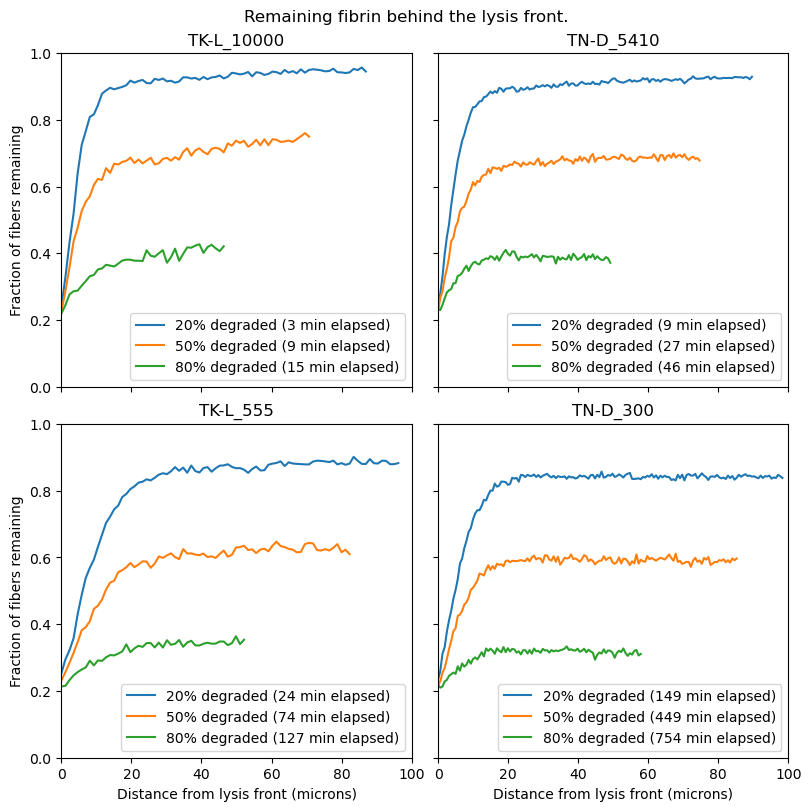

In [95]:
fig, axs = plt.subplots(
    nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8, 8), dpi=100, constrained_layout=True
)
labels = ["20%", "50%", "80%"]
for i, row in enumerate(scenario_grid_T):
    axs[1, i].set_xlabel("Distance from lysis front (microns)")
    axs[i, 0].set_ylabel("Fraction of fibers remaining")
    for j, scenario in enumerate(row):
        axs[i, j].set_title(scenario)
        axs[i, j].set_xlim(0,100)
        axs[i, j].set_ylim(0,1)
        for k in range(3):
            axs[i, j].plot(degradation_distance[scenario][k], degradation_amount[scenario][k], label=f"{labels[k]} degraded ({lysis_time[scenario][k]//60:n} min elapsed)")
        axs[i, j].legend(
            bbox_to_anchor=(1, 0),
            loc="lower right",
            ncols=1,
        )    
 
fig.suptitle(f"Remaining fibrin behind the lysis front.")
       
fig.savefig(f"degradation behind front.png", bbox_inches="tight")

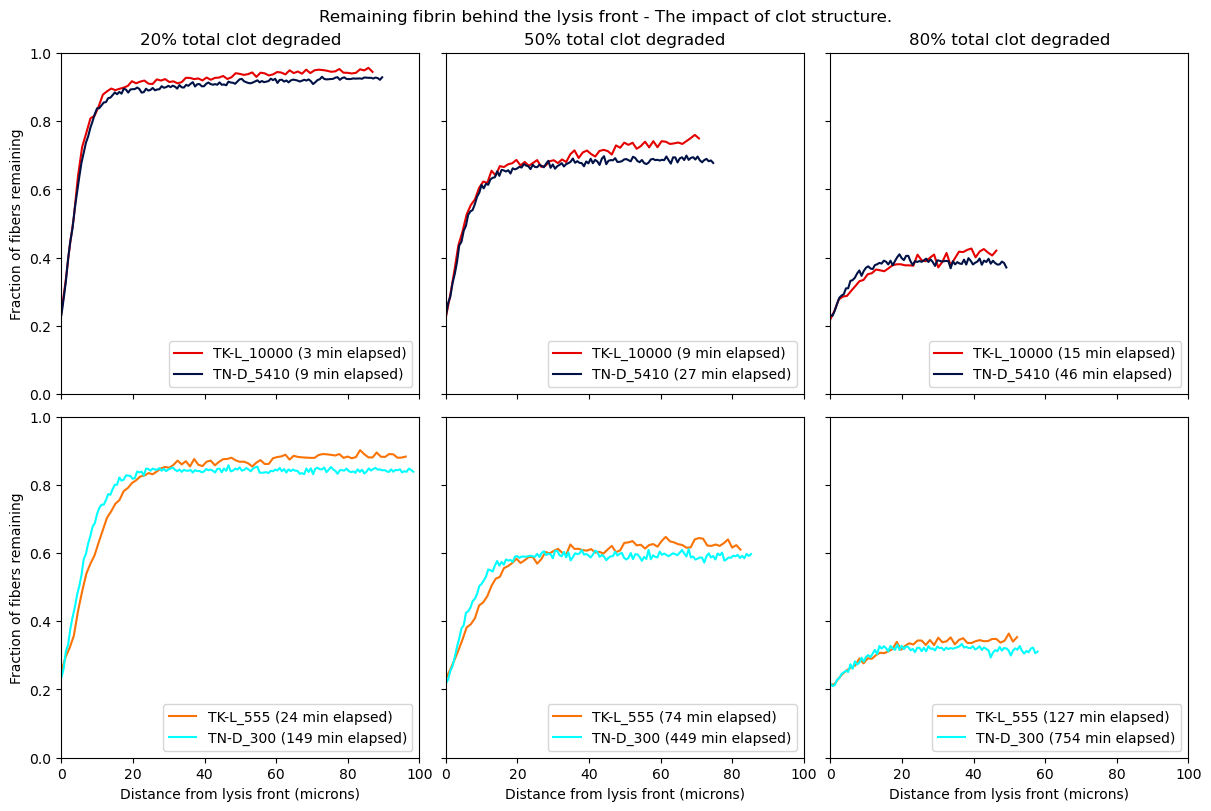

In [98]:
fig, axs = plt.subplots(
    nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12, 8), dpi=100, constrained_layout=True
)
labels = ["20%", "50%", "80%"]
for i, row in enumerate(scenario_grid_T):
    axs[i, 0].set_ylabel("Fraction of fibers remaining")
    for j in range(3):
        axs[1, j].set_xlabel("Distance from lysis front (microns)")
        axs[0, j].set_title(labels[j]+" total clot degraded")
        axs[i, j].set_xlim(0,100)
        axs[i, j].set_ylim(0,1)
        
        for k, scenario in enumerate(row):
            axs[i, j].plot(degradation_distance[scenario][j], degradation_amount[scenario][j], label=f"{scenario} ({lysis_time[scenario][j]//60:n} min elapsed)", color=colors[scenario])
        axs[i, j].legend(
            bbox_to_anchor=(1, 0),
            loc="lower right",
            ncols=1,
        )
 
fig.suptitle(f"Remaining fibrin behind the lysis front - The impact of clot structure.")
           
fig.savefig(f"degradation behind front by structure by overall degradation.png", bbox_inches="tight")

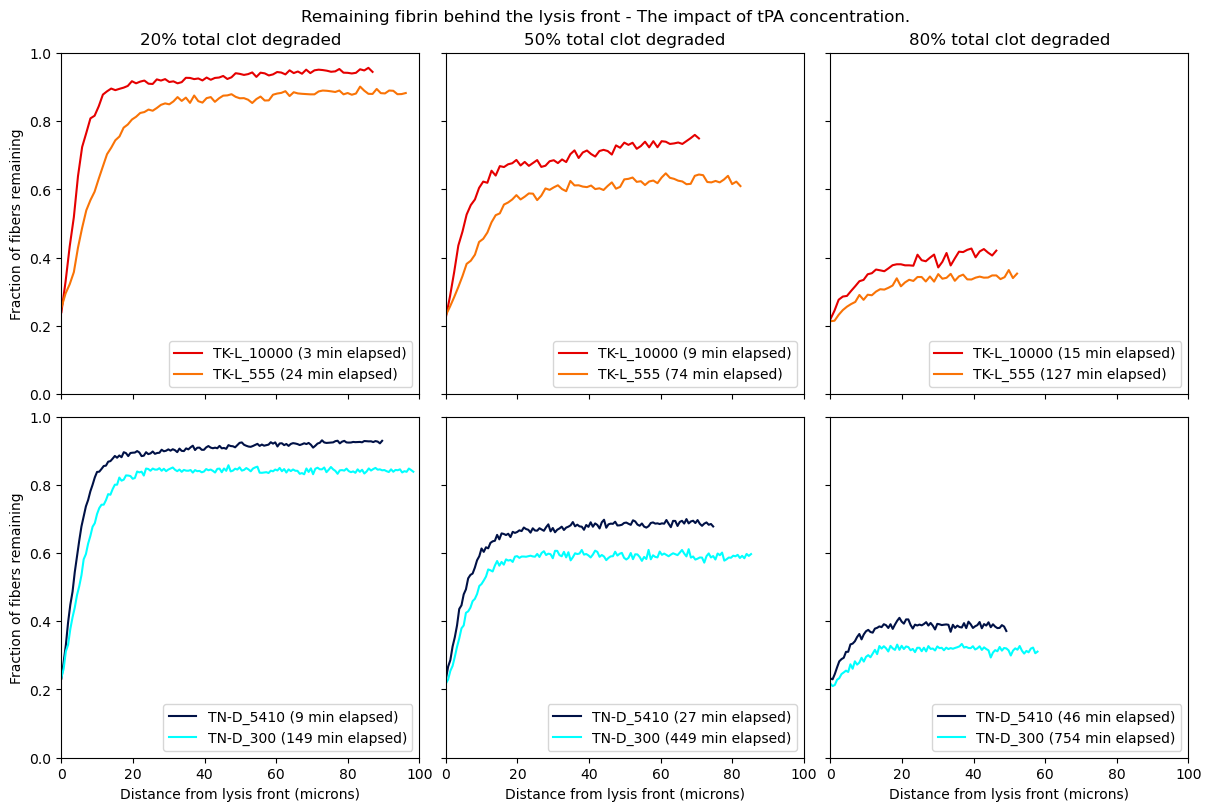

In [99]:
fig, axs = plt.subplots(
    nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12, 8), dpi=100, constrained_layout=True
)
labels = ["20%", "50%", "80%"]
for i, row in enumerate(scenario_grid):
    axs[i, 0].set_ylabel("Fraction of fibers remaining")
    for j in range(3):
        axs[1, j].set_xlabel("Distance from lysis front (microns)")
        axs[0, j].set_title(labels[j]+" total clot degraded")
        axs[i, j].set_xlim(0,100)
        axs[i, j].set_ylim(0,1)
        
        for k, scenario in enumerate(row):
            axs[i, j].plot(degradation_distance[scenario][j], degradation_amount[scenario][j], label=f"{scenario} ({lysis_time[scenario][j]//60:n} min elapsed)", color=colors[scenario])
        axs[i, j].legend(
            bbox_to_anchor=(1, 0),
            loc="lower right",
            ncols=1,
        )
 
fig.suptitle(f"Remaining fibrin behind the lysis front - The impact of tPA concentration.")
           
fig.savefig(f"degradation behind front by tPA concentration by overall degradation.png", bbox_inches="tight")

### Degradation behind front t min after tPA insertion

In [20]:
times = [5*60, 10*60, 15*60]
degradation_amount = {}
degradation_distance = {}
total_deg_amount = {}
for i, run in enumerate(runs):
    # Select and load scenario
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
    e.read_file()
    y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
    file_code = out_file_code.format(scenario_code=run["scenario"]) + ".dat"

    print(run["exp_code"], file_code[1:-4])

    # Read data from data files
    n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

    # Process results
    deg_fraction = find_degraded_fraction(e, deg, tsave)
    marker_frames = find_degradation_marker_frames(e, deg_fraction, degrade_percent_markers)

    row_deg = find_row_deg_fraction(e, deg, tsave)
    fronts = find_front(e, row_deg)

    frames = [[t//e.macro_params.save_interval for t in times] for i in range(e.macro_params.total_trials)]

    total_deg_amount[run["scenario"]] = [np.mean([deg_fraction[i][frames[i][j]] for i in range(e.macro_params.total_trials)]) for j in range(len(times))]

    lengths=[np.max(np.stack([fronts[i][frames[i][j]] for i in range(e.macro_params.total_trials)]), axis=0) for j in range(len(times))]
    degradation_amount[run["scenario"]] = [np.mean(np.stack([row_deg[i][frames[i][j],fronts[i][frames[i][j]]:fronts[i][frames[i][j]]+e.macro_params.fiber_rows-1-lengths[j]] for i in range(e.macro_params.total_trials)]), axis=0) for j in range(len(times))]
    degradation_distance[run["scenario"]] = [[i*e.macro_params.grid_node_distance for i in range(degradation_amount[run["scenario"]][j].size)] for j in range(len(times))]

    # edge_index = get_edge_index(e)
    # x1_f, y1_f, x2_f, y2_f = grid_data(e, edge_index)
    # create_fiber_grid_plot(e, file_code, edge_index, frames, deg, tsave, x1_f, y1_f, x2_f, y2_f, fronts=fronts)

2024-01-26-1000 TK-L_10000
2024-01-26-1001 TK-L_555
2024-01-26-1002 TN-D_5410
2024-01-26-1003 TN-D_300


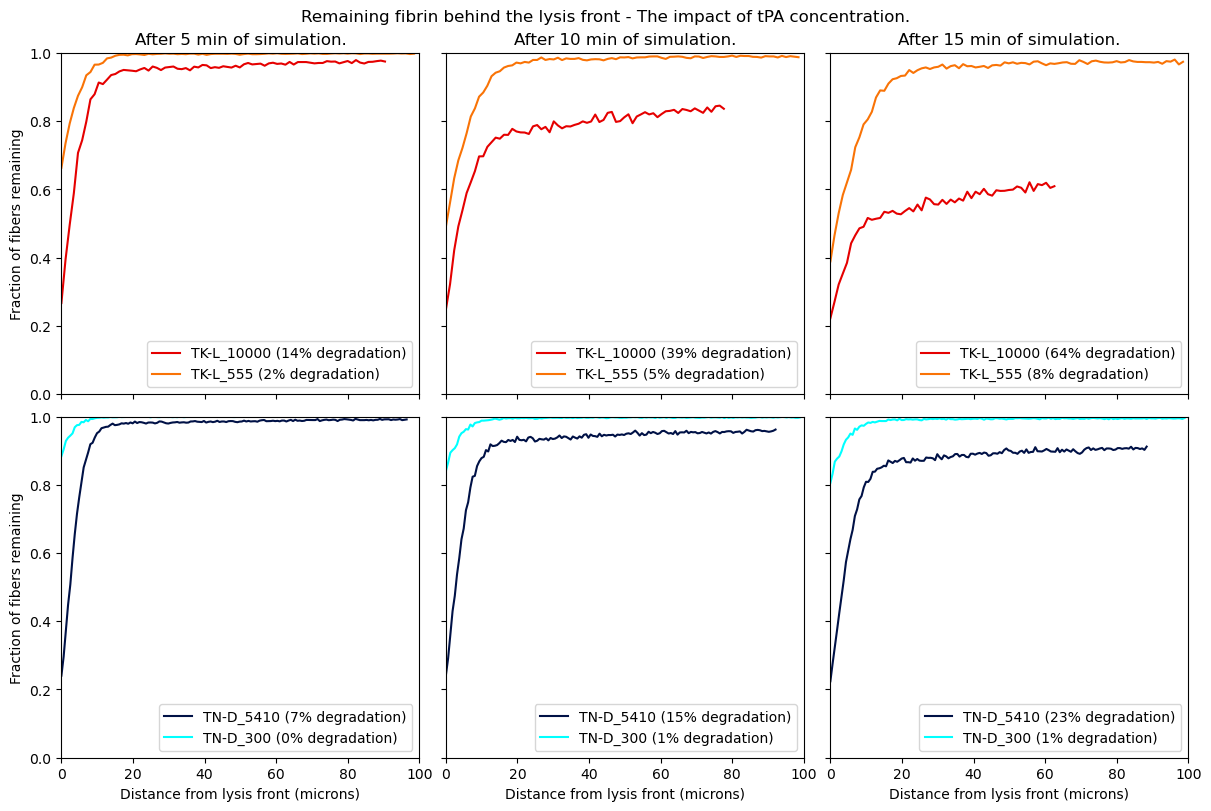

In [21]:
fig, axs = plt.subplots(
    nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12, 8), dpi=100, constrained_layout=True
)
for i, row in enumerate(scenario_grid):
    axs[i, 0].set_ylabel("Fraction of fibers remaining")
    for j in range(3):
        axs[1, j].set_xlabel("Distance from lysis front (microns)")
        axs[0, j].set_title(f"After {times[j]//60:n} min of simulation.")
        axs[i, j].set_xlim(0,100)
        axs[i, j].set_ylim(0,1)

        for k, scenario in enumerate(row):
            axs[i, j].plot(degradation_distance[scenario][j], degradation_amount[scenario][j], label=scenario + f" ({total_deg_amount[scenario][j]:2.0%} degradation)", color=colors[scenario])
        axs[i, j].legend(
            bbox_to_anchor=(1, 0),
            loc="lower right",
            ncols=1,
        )

fig.suptitle(f"Remaining fibrin behind the lysis front - The impact of tPA concentration.")

fig.savefig(f"degradation behind front by tPA concentration by time after 0.png", bbox_inches="tight")

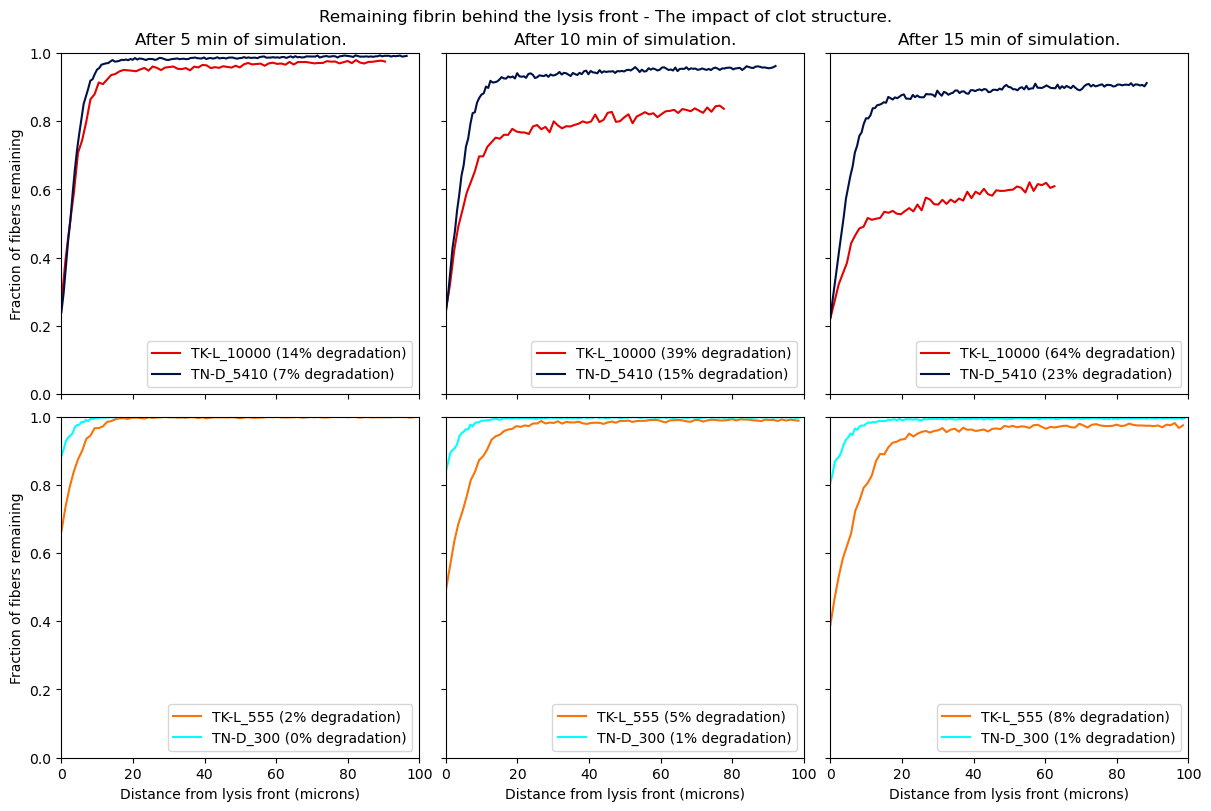

In [22]:
fig, axs = plt.subplots(
    nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12, 8), dpi=100, constrained_layout=True
)
for i, row in enumerate(scenario_grid_T):
    axs[i, 0].set_ylabel("Fraction of fibers remaining")
    for j in range(3):
        axs[1, j].set_xlabel("Distance from lysis front (microns)")
        axs[0, j].set_title(f"After {times[j]//60:n} min of simulation.")
        axs[i, j].set_xlim(0,100)
        axs[i, j].set_ylim(0,1)

        for k, scenario in enumerate(row):
            axs[i, j].plot(degradation_distance[scenario][j], degradation_amount[scenario][j], label=f"{scenario} ({total_deg_amount[scenario][j]:2.0%} degradation)", color=colors[scenario])
        axs[i, j].legend(
            bbox_to_anchor=(1, 0),
            loc="lower right",
            ncols=1,
        )

fig.suptitle(f"Remaining fibrin behind the lysis front - The impact of clot structure.")

fig.savefig(f"degradation behind front by structure by time after 0.png", bbox_inches="tight")

### Degradation behind front 5 min after 5% degradation

In [84]:
times = [5*60, 10*60, 15*60]
degradation_amount = {}
degradation_distance = {}
total_deg_amount = {}
for i, run in enumerate(runs):
    # Select and load scenario
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
    e.read_file()
    y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
    file_code = out_file_code.format(scenario_code=run["scenario"]) + ".dat"

    print(run["exp_code"], file_code[1:-4])

    # Read data from data files
    n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

    # Process results
    deg_fraction = find_degraded_fraction(e, deg, tsave)
    marker_frames = find_degradation_marker_frames(e, deg_fraction, degrade_percent_markers)

    row_deg = find_row_deg_fraction(e, deg, tsave)
    fronts = find_front(e, row_deg)
    
    frames = [[marker_frames[i][0] + t//e.macro_params.save_interval for t in times] for i in range(e.macro_params.total_trials)]
    
    # TODO(bpaynter): Add label with degradation total
    total_deg_amount[run["scenario"]] = [np.mean([deg_fraction[i][frames[i][j]] for i in range(e.macro_params.total_trials)]) for j in range(len(times))]
    
    lengths=[np.max(np.stack([fronts[i][frames[i][j]] for i in range(e.macro_params.total_trials)]), axis=0) for j in range(len(times))]
    degradation_amount[run["scenario"]] = [np.mean(np.stack([row_deg[i][frames[i][j],fronts[i][frames[i][j]]:fronts[i][frames[i][j]]+e.macro_params.fiber_rows-1-lengths[j]] for i in range(e.macro_params.total_trials)]), axis=0) for j in range(len(times))]
    degradation_distance[run["scenario"]] = [[i*e.macro_params.grid_node_distance for i in range(degradation_amount[run["scenario"]][j].size)] for j in range(len(times))]
    
    edge_index = get_edge_index(e)
    x1_f, y1_f, x2_f, y2_f = grid_data(e, edge_index)
    create_fiber_grid_plot(e, file_code, edge_index, frames, deg, tsave, x1_f, y1_f, x2_f, y2_f, fronts=fronts)

2024-01-26-1000 TK-L_10000
2024-01-26-1001 TK-L_555
2024-01-26-1002 TN-D_5410
2024-01-26-1003 TN-D_300


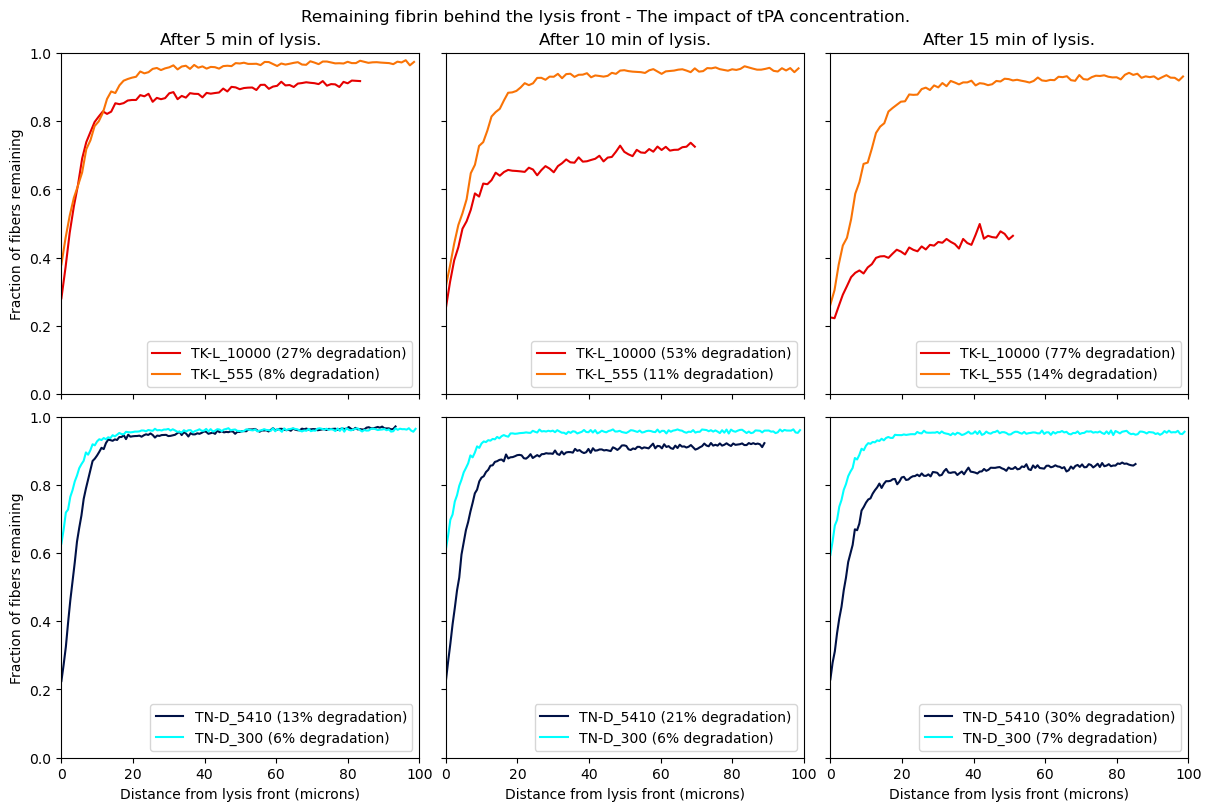

In [92]:
fig, axs = plt.subplots(
    nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12, 8), dpi=100, constrained_layout=True
)
for i, row in enumerate(scenario_grid):
    axs[i, 0].set_ylabel("Fraction of fibers remaining")
    for j in range(3):
        axs[1, j].set_xlabel("Distance from lysis front (microns)")
        axs[0, j].set_title(f"After {times[j]//60:n} min of lysis.")
        axs[i, j].set_xlim(0,100)
        axs[i, j].set_ylim(0,1)
        
        for k, scenario in enumerate(row):
            axs[i, j].plot(degradation_distance[scenario][j], degradation_amount[scenario][j], label=scenario + f" ({total_deg_amount[scenario][j]:2.0%} degradation)", color=colors[scenario])
        axs[i, j].legend(
            bbox_to_anchor=(1, 0),
            loc="lower right",
            ncols=1,
        )
        
fig.suptitle(f"Remaining fibrin behind the lysis front - The impact of tPA concentration.")
           
fig.savefig(f"degradation behind front by tPA concentration by time.png", bbox_inches="tight")

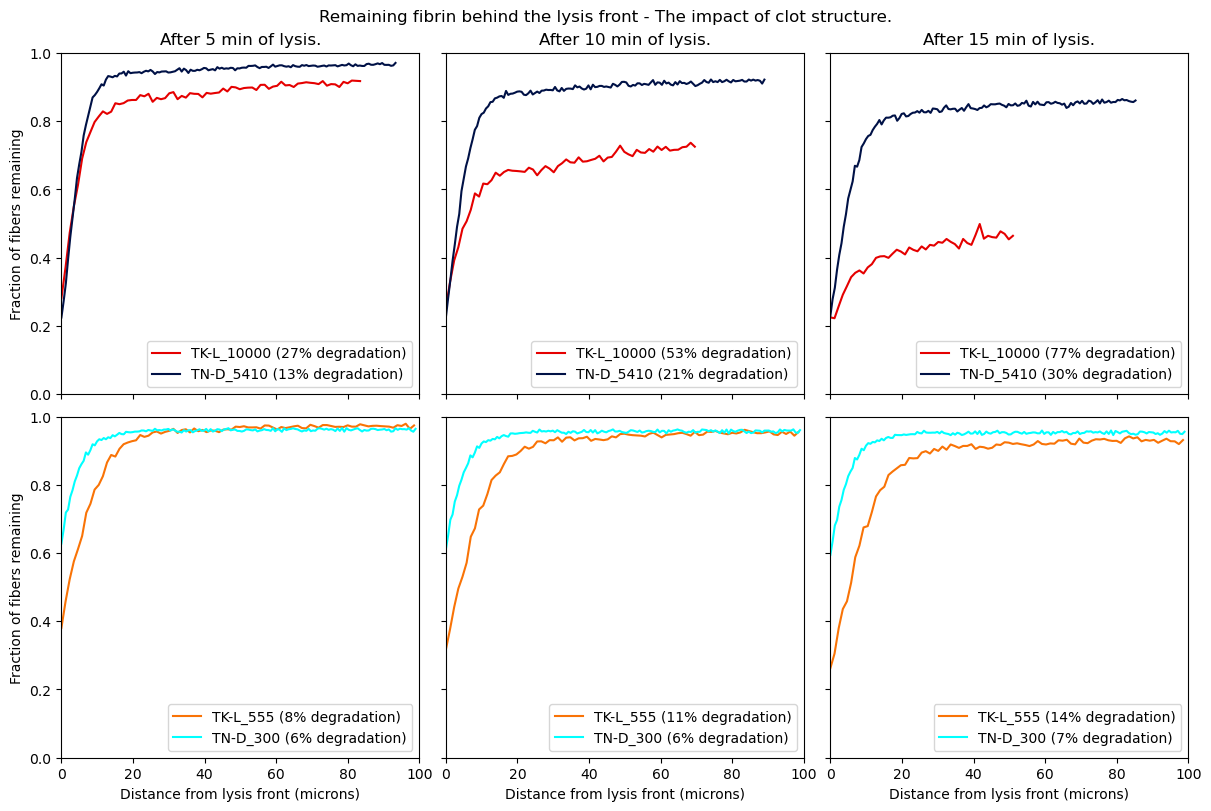

In [93]:
fig, axs = plt.subplots(
    nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12, 8), dpi=100, constrained_layout=True
)
for i, row in enumerate(scenario_grid_T):
    axs[i, 0].set_ylabel("Fraction of fibers remaining")
    for j in range(3):
        axs[1, j].set_xlabel("Distance from lysis front (microns)")
        axs[0, j].set_title(f"After {times[j]//60:n} min of lysis.")
        axs[i, j].set_xlim(0,100)
        axs[i, j].set_ylim(0,1)
        
        for k, scenario in enumerate(row):
            axs[i, j].plot(degradation_distance[scenario][j], degradation_amount[scenario][j], label=f"{scenario} ({total_deg_amount[scenario][j]:2.0%} degradation)", color=colors[scenario])
        axs[i, j].legend(
            bbox_to_anchor=(1, 0),
            loc="lower right",
            ncols=1,
        )
# fig, axs = plt.subplots(
#     nrows=1, ncols=2, sharex=True, sharey=True, figsize=(8, 4), dpi=100, constrained_layout=True
# )
# for i, row in enumerate(scenario_grid_T):
#     axs[i].set_xlabel("Distance from lysis front (microns)") 
#     for k, scenario in enumerate(row):
#         axs[i].plot(degradation_distance[scenario], degradation_amount[scenario], label=f"{scenario} ({total_deg_amount[scenario]:2.0%} degraded)", color=colors[scenario])
#     axs[i].legend(
#         bbox_to_anchor=(1, 0),
#         loc="lower right",
#         ncols=1,
#     )
 

fig.suptitle(f"Remaining fibrin behind the lysis front - The impact of clot structure.")
           
fig.savefig(f"degradation behind front by structure by time.png", bbox_inches="tight")

### Print state plots with front

In [ ]:
fig, axs = plt.subplots(
    nrows=3, ncols=4, sharex=False, sharey=False, figsize=(20, 20), dpi=100, constrained_layout=True
)
sim = 0
frac = 0.50
for i, run in enumerate(runs):
    # Select and load scenario
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
    # e = lysis.util.Experiment(
    #     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
    # )
    e.read_file()
    y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
    file_code = out_file_code.format(scenario_code=run["scenario"]) + ".dat"

    print(run["exp_code"], file_code[1:-4])

    # Read data from data files
    n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

    # Process results
    deg_fraction = find_degraded_fraction(e, deg, tsave)
    marker_frames = find_degradation_marker_frames(e, deg_fraction, degrade_percent_markers)

    row_deg = find_row_deg_fraction(e, deg, tsave)
    fronts = [np.argmax(sim_row_deg >= frac, axis=1) for sim_row_deg in row_deg]
    edge_index = get_edge_index(e)
    x_f, y_f, x_m, y_m = animation_data(e, edge_index, mol_location)
    #np.delete(marker_frames, -1, axis=-1)
    for j, frame in enumerate(marker_frames[sim, :4]):
        #axs[i, j] = fig.add_axes([0, 0, 1, 1])
        axs[i, j].set_axis_off()
        vmin = 0
        vmax = e.macro_params.cols - 1

        ydiff = e.macro_params.rows - e.macro_params.cols

        axs[i, j].set_xlim(vmin - 0.25, vmax + 0.25)
        axs[i, j].set_ylim(-vmax - ydiff - 0.25, -vmin + 0.25)
        axs[i, j].set_aspect("equal")
        #fig.canvas.draw()
        title = axs[i, j].annotate(
            f"Simulation time elapsed: {str(datetime.timedelta(seconds=tsave[sim][frame])).split('.')[0]}",
            (0, 0),
            zorder=100,
            va="top",
        )
        s = (axs[i, j].get_window_extent().width / (vmax - vmin + 0.5) * 72 / (2 * fig.dpi)) ** 2
        scatt_f = axs[i, j].scatter(
            x_f,
            y_f,
            s=s,
            marker="s",
            linewidths=0,
            c=deg[sim][frame],
            cmap=colormap_f,
            vmin=e.macro_params.time_step,
            vmax=tsave[sim][frame],
        )
        # scatt_m = axs[i, j].scatter(
        #     x_m[sim][frame],
        #     y_m[sim][frame],
        #     s=s / 2.5,
        #     marker="o",
        #     linewidths=0,
        #     c=mol_status[sim][frame],
        #     cmap=colormap_m,
        #     norm=norm_m,
        # )
        front_line = axs[i, j].axhline(y=y_f[(e.macro_params.empty_rows+fronts[sim][frame])*e.macro_params.full_row], color="xkcd:hot pink")

fig.savefig(f"degradation front {frac:.0%}.png", bbox_inches="tight")
pass

## Print tables of data

In [19]:
for run in tqdm(runs):
    # Select and load scenario
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
    # e = lysis.util.Experiment(
    #     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
    # )
    e.read_file()
    y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
    file_code = out_file_code.format(scenario_code=run["scenario"]) + ".dat"

    # Get processing time and print
    time = get_processing_time(e, file_code, mech).mean()
    time = str(datetime.timedelta(seconds=time)).split(".")[0]
    print(run["exp_code"], file_code[1:-4], f" - Mean Simulation Processing Time: {time}")

    # Read data from log files
    total_binds = get_total_binds(e, file_code, mech)
    macro_unbinds, micro_unbinds = get_unbind_amounts(e, file_code, mech)
    normal_unbinds = total_binds - (macro_unbinds + micro_unbinds)
    mol_time_df.loc[
        scen["descriptor"], "Total Binds"
    ] = f"{total_binds.mean():,.0f} \u00B1 {total_binds.std():,.0f}"
    mol_time_df.loc[scen["descriptor"], "Macro Unbinds %"] = f"{(macro_unbinds / total_binds).mean():.3%}"
    mol_time_df.loc[scen["descriptor"], "Micro Unbinds %"] = f"{(micro_unbinds / total_binds).mean():.3%}"

    # Read data from data files
    n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

    # Read parameters into a dataframe
    params = e.macro_params
    df = pd.DataFrame([params])
    parameters_df.loc[scen["descriptor"]] = df.loc[0]
    if e.macro_params.total_time == 0:
        parameters_df.loc[scen["descriptor"], "total_time"] = max([i[-1] for i in tsave])
        parameters_df.loc[scen["descriptor"], "total_time_steps"] = max(
            [int(i[-1] // e.macro_params.time_step) for i in tsave]
        )
        parameters_df.loc[scen["descriptor"], "number_of_saves"] = max(n_save)

    binds_df.loc[scen["descriptor"]] = get_total_binds(e, file_code, mech)

    # Process results
    deg_fraction = find_degraded_fraction(e, deg, tsave)
    marker_frames = find_degradation_marker_frames(e, deg_fraction, degrade_percent_markers)
    marker_times = find_degradation_marker_times(e, marker_frames, tsave)
    degradation_time_df.loc[run["scenario"]] = marker_times.T.flatten()
    slopes = degradation_rates(e, marker_frames, deg_fraction, tsave)
    slopes_df.loc[run["scenario"]] = slopes.T.flatten()

  0%|          | 0/4 [00:00<?, ?it/s]

2024-01-26-1000 TK-L_10000  - Mean Simulation Processing Time: 0:21:09
2024-01-26-1001 TK-L_555  - Mean Simulation Processing Time: 0:03:41
2024-01-26-1002 TN-D_5410  - Mean Simulation Processing Time: 1:09:19
2024-01-26-1003 TN-D_300  - Mean Simulation Processing Time: 0:31:47


In [20]:
## Parameters table
units = lysis.util.MacroParameters.units()
rename = {}
for k, v in units.items():
    rename[k] = f"{k} ({v})"
printable_parameters_df = pd.DataFrame(index=parameters_df.index)
for col in parameters_df.columns:
    if not col in cols_to_drop:
        if col in formats:
            printable_parameters_df[col] = parameters_df[col].apply(lambda x: formats[col].format(x))
        else:
            printable_parameters_df[col] = parameters_df[col]
printable_parameters_df = printable_parameters_df.rename(columns=rename)
print(printable_parameters_df.T.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Scenario</th>
      <th>TK-L_10000</th>
      <th>TK-L_555</th>
      <th>TN-D_5410</th>
      <th>TN-D_300</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>binding_rate ((micromolar*sec)^-1)</th>
      <td>0.10</td>
      <td>0.10</td>
      <td>0.10</td>
      <td>0.10</td>
    </tr>
    <tr>
      <th>pore_size (centimeters)</th>
      <td>1.01350e-04</td>
      <td>1.01350e-04</td>
      <td>5.49500e-05</td>
      <td>5.49500e-05</td>
    </tr>
    <tr>
      <th>diffusion_coeff (cm^2/s)</th>
      <td>5.00000e-07</td>
      <td>5.00000e-07</td>
      <td>5.00000e-07</td>
      <td>5.00000e-07</td>
    </tr>
    <tr>
      <th>binding_sites (micromolar)</th>
      <td>213</td>
      <td>213</td>
      <td>427</td>
      <td>427</td>
    </tr>
    <tr>
      <th>forced_unbind</th>
      <td>0.073</td>
      <td>0.073</td>
      <td>0.085</td>
      <td>0.085</td>
    </tr>
    <tr>
   

In [21]:
## Degradation Rate Table
m = slopes_df.groupby(axis=1, level=0).mean()
s = slopes_df.groupby(axis=1, level=0).std()
slopes_summary = pd.DataFrame(index=slopes_df.index, columns=slopes_df.columns.get_level_values(0).unique())
for i in slopes_summary.index:
    for j in slopes_summary.columns:
        slopes_summary.loc[i, j] = f"{m.loc[i, j]:.6f} \u00B1 {s.loc[i, j]:.6f}"
print(slopes_summary.to_html())
# print(slopes_summary.to_markdown())
# slopes_summary

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Degradation Interval</th>
      <th>20% to 80%</th>
      <th>20% to 50%</th>
      <th>50% to 80%</th>
    </tr>
    <tr>
      <th>Scenario</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>TK-L_10000</th>
      <td>0.048962 ± 0.000522</td>
      <td>0.050786 ± 0.000563</td>
      <td>0.047241 ± 0.000689</td>
    </tr>
    <tr>
      <th>TK-L_555</th>
      <td>0.005843 ± 0.000085</td>
      <td>0.005989 ± 0.000089</td>
      <td>0.005705 ± 0.000105</td>
    </tr>
    <tr>
      <th>TN-D_5410</th>
      <td>0.016026 ± 0.000051</td>
      <td>0.016659 ± 0.000094</td>
      <td>0.015441 ± 0.000048</td>
    </tr>
    <tr>
      <th>TN-D_300</th>
      <td>0.000992 ± 0.000003</td>
      <td>0.000998 ± 0.000005</td>
      <td>0.000986 ± 0.000006</td>
    </tr>
  </tbody>
</table>


C:\Users\bradp\AppData\Local\Temp\ipykernel_18928\792576897.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  m = slopes_df.groupby(axis=1, level=0).mean()
C:\Users\bradp\AppData\Local\Temp\ipykernel_18928\792576897.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  s = slopes_df.groupby(axis=1, level=0).std()


In [22]:
## Degradation Time Table
m = degradation_time_df.groupby(axis=1, level=0).mean()
s = degradation_time_df.groupby(axis=1, level=0).std()
degradation_time_summary = pd.DataFrame(
    index=degradation_time_df.index, columns=degradation_time_df.columns.get_level_values(0).unique()
)
for i in degradation_time_summary.index:
    for j in degradation_time_summary.columns:
        degradation_time_summary.loc[i, j] = f"{m.loc[i, j]:.2f} \u00B1 {s.loc[i, j]:.2f}"
#print(degradation_time_summary.to_markdown())
print(degradation_time_summary.to_html())
#print(degradation_time_summary)

C:\Users\bradp\AppData\Local\Temp\ipykernel_18928\2804788232.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  m = degradation_time_df.groupby(axis=1, level=0).mean()


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Percent Degraded</th>
      <th>5%</th>
      <th>20%</th>
      <th>50%</th>
      <th>80%</th>
      <th>100%</th>
    </tr>
    <tr>
      <th>Scenario</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>TK-L_10000</th>
      <td>2.67 ± 0.00</td>
      <td>6.28 ± 0.08</td>
      <td>12.23 ± 0.12</td>
      <td>18.53 ± 0.17</td>
      <td>27.50 ± 0.28</td>
    </tr>
    <tr>
      <th>TK-L_555</th>
      <td>10.45 ± 0.25</td>
      <td>35.22 ± 0.42</td>
      <td>85.33 ± 0.93</td>
      <td>137.97 ± 1.63</td>
      <td>187.50 ± 1.85</td>
    </tr>
    <tr>
      <th>TN-D_5410</th>
      <td>4.00 ± 0.00</td>
      <td>13.32 ± 0.05</td>
      <td>31.28 ± 0.11</td>
      <td>50.73 ± 0.16</td>
      <td>69.58 ± 0.26</td>
    </tr>
    <tr>
      <th>TN-D_300</th>
      <td>51.33 ± 1.31</td>
      <td>200.67 ± 2.11<

C:\Users\bradp\AppData\Local\Temp\ipykernel_18928\2804788232.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  s = degradation_time_df.groupby(axis=1, level=0).std()


In [ ]:
print(
    results["Front Velocity (microns/min)"]
    .apply(lambda x: f"{x[0]:,.0f} \u00B1 {x[1]:,.0f}", axis=1)
    .unstack(0)
    .loc[mechanisms["descriptor"], scenarios["descriptor"]]
    #.style.to_latex()
    # .to_html()
)

## Pore size calculations
### Comparison to random pores

In [ ]:
rng1 = np.random.default_rng()

In [ ]:
##################################
## Generate pores with random degradation
##################################
exp = None
random_pore_data = {}
trials = 10_000
percent = 0.8
for run in [r for r in runs if r["scenario"][-3:] == "307"]:
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
    # e = lysis.util.Experiment(
    #     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
    # )
    e.read_file()
    total = e.macro_params.total_fibers
    rev_edge_index = get_rev_edge_index(e)
    num_of_lines = 25
    v_step = (e.macro_params.cols - 1) // num_of_lines
    v_lines = range(v_step // 2, e.macro_params.cols - 1, v_step)
    h_step = (e.macro_params.rows - 1) // num_of_lines
    h_lines = range(h_step // 2, e.macro_params.rows - 1, h_step)
    min_time = np.min(n_save)
    pores = []
    for sim in trange(trials):
        pores.append([])
        lines = []
        remove = rng1.choice(np.arange(total), size=math.floor(total * percent), replace=False)
        degraded = np.full(total, False)
        for i in remove:
            degraded[i] = True
        for j in v_lines:
            pores_in_line = []
            current_pore = e.macro_params.grid_node_distance  # e.macro_params.pore_size * 10_000
            # if degraded[rev_edge_index[0, j * 3 + 2]]:
            #     current_pore += exp.macro_params.grid_node_distance - exp.macro_params.pore_size * 10_000
            for i in range(1, e.macro_params.rows - 1):
                if degraded[rev_edge_index[i, j * 3 + 2]]:
                    current_pore += e.macro_params.grid_node_distance
                else:
                    pores_in_line.append(current_pore)
                    current_pore = e.macro_params.grid_node_distance  # e.macro_params.pore_size * 10_000
            # if degraded[rev_edge_index[-1, j * 3 + 2]]:
            #     current_pore += exp.macro_params.grid_node_distance - exp.macro_params.pore_size * 10_000
            pores_in_line.append(current_pore)
            lines.append(np.array(pores_in_line))
        for i in h_lines:
            pores_in_line = []
            current_pore = e.macro_params.grid_node_distance  # e.macro_params.pore_size * 10_000
            # if degraded[rev_edge_index[i, 0]]:
            #     current_pore += exp.macro_params.grid_node_distance - exp.macro_params.pore_size * 10_000
            for j in range(1, e.macro_params.cols - 1):
                if degraded[rev_edge_index[i, j * 3]]:
                    current_pore += e.macro_params.grid_node_distance
                else:
                    pores_in_line.append(current_pore)
                    current_pore = e.macro_params.grid_node_distance  # e.macro_params.pore_size * 10_000
            # if degraded[rev_edge_index[i, -1]]:
            #     current_pore += exp.macro_params.grid_node_distance - exp.macro_params.pore_size * 10_000
            pores_in_line.append(current_pore)
            lines.append(np.array(pores_in_line))
        pores_at_frame = np.empty(0, dtype=float)
        for line in lines:
            pores_at_frame = np.append(pores_at_frame, line)
        pores[sim].append(
            pores_at_frame / e.macro_params.grid_node_distance
        )  # (e.macro_params.pore_size * 10_000))
    random_pore_data[scen["descriptor"]] = [pores[sim][0] for sim in range(trials)]

In [ ]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=4,
    sharex=False,
    sharey=True,
    figsize=(12, 6),
    constrained_layout=True,
    # width_ratios=[2, 1, 1, 1, 1],
)
for i, row in enumerate(scenario_grid):
    axs[0].set_ylabel("pore size\n(as a multiple of grid node distance")  # initial pore size)")
    # for j, scenario in enumerate(row):
    #     axs[i, j + 2].boxplot(
    #         [pore_plot_data[scenario][0.8][sim] for sim in range(10)],
    #         # showfliers=False,
    #         whis=[0.01, 0.99],
    #     )
    #     # axs[i].set_xticks(
    #     #     range(1, len(row) + 1),
    #     #     labels=[f"{scenario}" for scenario in row],
    #     # )
    #     axs[i, j + 2].set_title(scenario)
    axs[i].boxplot(
        [np.concatenate(pore_plot_data[scenario][percent]) for scenario in row],
        showfliers=False,
        whis=(1, 99),
    )
    axs[i].set_xticks(
        range(1, len(row) + 1),
        labels=[f"{scenario}" for scenario in row],
        rotation=-45,
    )
    axs[i].set_title(groupings[i])
    axs[i].grid(visible=True, which="major", axis="y")
    # axs[i, 1].boxplot(
    #     random_pore_data[f"{row[0][:5]}307"],
    #     showfliers=False,
    # )
    # axs[i, 1].set_title(f"{row[0][:5]}Control")
axs[-1].boxplot(
    [np.concatenate(random_pore_data[f"{scenario[:5]}307"]) for scenario in scenario_grid[0]],
    showfliers=False,
    whis=(1, 99),
)
axs[-1].set_xticks(
    range(1, len(row) + 1),
    labels=[f"{scenario[:5]}Control" for scenario in scenario_grid[0]],
    rotation=-45,
)
axs[-1].set_title("Random Control")
axs[-1].grid(visible=True, which="major", axis="y")
fig.suptitle(
    f"Distribution of pore sizes at {percent:.0%} degradation.\n(Boxes are Q1 to Q3; Whiskers are 1st percentile to 99th percentile)"
)
pass

In [ ]:
# 10_000 samples
# 80% degraded
for run in runs:
    print(
        run["scenario"],
        scipy.stats.ks_2samp(
            np.concatenate(pore_plot_data[run["scenario"]][0.8]),
            np.concatenate(random_pore_data[f"{run['scenario'][:5]}307"]),
        ),
    )

In [ ]:
# 100 samples
for run in runs:
    print(
        run["scenario"],
        scipy.stats.ks_2samp(
            np.concatenate(pore_plot_data[run["scenario"]][0.8]),
            np.concatenate(random_pore_data[f"{run['scenario'][:5]}307"]),
        ),
    )

In [ ]:
scipy.stats.anderson(np.concatenate(random_pore_data[f"TK-L_307"]), dist="expon")

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=True, figsize=(12, 6), constrained_layout=True)
for i, row in enumerate(scenario_grid_T):
    axs[i].set_yscale("log")
    for j, scenario in enumerate(row):
        combined_sims = np.concatenate(pore_plot_data[scenario][percent])
        hist = np.array([(i, np.count_nonzero(combined_sims == i)) for i in np.unique(combined_sims)])
        axs[i].plot(
            hist.T[0], hist.T[1] * 100 / combined_sims.shape[0], color=colors[scenario], label=scenario
        )
    combined_sims = np.concatenate(random_pore_data[f"{row[0][:5]}307"])
    hist = np.array([(i, np.count_nonzero(combined_sims == i)) for i in np.unique(combined_sims)])
    axs[i].plot(hist.T[0], (hist.T[1]) * 100 / combined_sims.shape[0], label=f"{row[0][:5]}Control")
    axs[i].set_xlabel("Pore size (in multiples of grid distance)")
    axs[i].legend()
axs[0].set_ylabel("Percent of pores (log scale)")
fig.suptitle(f"Distribution of pore sizes at {percent:.0%} degradation.")
pass

In [ ]:
run = runs[0]
sim = 0
scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
scen

In [ ]:
mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
# e = lysis.util.Experiment(
#     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
# )
e.read_file()
y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
file_code = out_file_code.format(scenario_code=run["scenario"]) + ".dat"
print(run["exp_code"], file_code)
n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

deg_fraction = find_degraded_fraction(e, deg, tsave)
marker_frames = find_degradation_marker_frames(e, deg_fraction)
marker_times = find_degradation_marker_times(e, marker_frames, tsave)
edge_index = get_edge_index(e)
x1_f, y1_f, x2_f, y2_f = grid_data(e, edge_index)

In [ ]:
mol_bind_events = []
for sim in range(e.macro_params.total_trials):
    raw_mol_bind_events = np.loadtxt(
        os.path.join(e.os_path, f"{sim:02}", f"m_bind_t{file_code[:-4]}_{sim:02}{file_code[-4:]}"),
        delimiter=",",
    )
    sim_mol_bind_events = [[] for _ in range(e.macro_params.total_molecules)]
    for event in raw_mol_bind_events:
        sim_mol_bind_events[event[1].astype(int) - 1].append((event[0], event[2].astype(int)))
    mol_bind_events.append(sim_mol_bind_events)

In [ ]:
for sim in range(e.macro_params.total_trials):
    for m in range(e.macro_params.total_molecules):
        for event in range(len(mol_bind_events[sim][m]) - 1):
            if mol_bind_events[sim][m][event][1] == 0:
                if mol_bind_events[sim][m][event + 1][1] != 1:
                    print("ERROR: Full unbind NOT followed by bind!")
            if mol_bind_events[sim][m][event][1] == 1:
                if mol_bind_events[sim][m][event + 1][1] == 1:
                    print("ERROR: Two binds in a row!")
            if mol_bind_events[sim][m][event][1] == 2:
                if mol_bind_events[sim][m][event + 1][1] != 0:
                    print("ERROR: Macro-unbind NOT followed by full unbind!")
            if mol_bind_events[sim][m][event][1] == 3:
                if mol_bind_events[sim][m][event + 1][1] != 0:
                    print("ERROR: Macro-unbind NOT followed by full unbind!")

In [ ]:
dwell_times = []
transit_times = []
for sim in range(e.macro_params.total_trials):
    for m in range(e.macro_params.total_molecules):
        current_status = MolStatus.UNBOUND
        timer = 0.0
        for event in mol_bind_events[sim][m]:
            if current_status == MolStatus.UNBOUND and event[1] == MolStatus.BOUND:
                transit_times.append(event[0] - timer)
                timer = event[0]
                current_status = MolStatus.BOUND
            if current_status == MolStatus.BOUND and event[1] == MolStatus.UNBOUND:
                dwell_times.append(event[0] - timer)
                timer = event[0]
                current_status = MolStatus.UNBOUND
            # if current_status == MolStatus.BOUND and event[1] == MolStatus.MICRO_UNBOUND:
            #     # dwell_times.append(event[0] - timer)
            #     timer = event[0]
            #     current_status = MolStatus.UNBOUND

In [ ]:
np.array(dwell_times).mean(), np.array(dwell_times).std()

In [ ]:
np.array(transit_times).mean(), np.array(transit_times).std()

In [ ]:
binds = 0
macro_unbinds = 0
micro_unbinds = 0
for m in range(e.macro_params.total_molecules):
    for event in mol_bind_events[0][m]:
        if event[1] == MolStatus.BOUND:
            binds += 1
        if event[1] == MolStatus.MACRO_UNBOUND:
            macro_unbinds += 1
        if event[1] == MolStatus.MICRO_UNBOUND:
            micro_unbinds += 1
binds, macro_unbinds, micro_unbinds

In [ ]:
len(dwell_times)

In [ ]:
print(f"At {percent:.0%} degradation, percent of pores at initial size.")
for run in runs:
    a = (
        np.count_nonzero(np.concatenate(pore_plot_data[run["scenario"]][percent]) == 1)
        / np.concatenate(pore_plot_data[run["scenario"]][0.8]).size
    )
    b = (
        np.count_nonzero(np.concatenate(random_pore_data[f"{run['scenario'][:5]}307"]) == 1)
        / np.concatenate(random_pore_data[f"{run['scenario'][:5]}307"]).size
    )
    print(f"{run['scenario']}: Expected {b:.2%}; Actual {a:.2%}")

In [ ]:
(np.arange(30) * exp.macro_params.grid_node_distance + exp.macro_params.pore_size * 10_000) / (
    exp.macro_params.pore_size * 10_000
)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=True, figsize=(12, 6), constrained_layout=True)
axs.boxplot([random_pore_data[scenario] for scenario in random_pore_data.keys()], showfliers=False)
axs.set_xticks(
    range(1, len(random_pore_data) + 1),
    labels=[f"{scenario}" for scenario in random_pore_data.keys()],
)
pass

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=True, figsize=(12, 6), constrained_layout=True)
axs.boxplot([pore_plot_data[scenario][0.5] for scenario in pore_plot_data.keys()], showfliers=False)
axs.set_xticks(
    range(1, len(pore_plot_data) + 1),
    labels=[f"{scenario}" for scenario in pore_plot_data.keys()],
)

In [ ]:
random_pore_data["TN-L_307"].mean(), random_pore_data["TN-L_9350"].mean()

In [ ]:
random_pore_data["TK-L_307"]

In [ ]:
plt.boxplot([pore_data[sim][marker_frames[sim][3]] for sim in range(10)], showfliers=False)

In [ ]:
plt.boxplot(
    [random_pore_data["TK-D_307"]] + pore_plot_data["TK-D_307"] + pore_plot_data["TK-D_9350"],
    showfliers=False,
)
pass

In [ ]:
type(pore_plot_data["TK-D_307"])

In [ ]:
16**0.5

In [ ]:
lysis.util.EdgeGrid.get_spacial_coordinates(12, 16)

In [ ]:
run = runs[0]
sim = 0
mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
e.read_file()

In [ ]:
lysis.util.EdgeGrid.get_distance(e, (3, 8), (5, 1))

In [ ]:
e.macro_params.grid_node_distance

In [ ]:
for run in tqdm(runs):
    # Select and load scenario
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
    # e = lysis.util.Experiment(
    #     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
    # )
    e.read_file()
    y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
    file_code = out_file_code.format(scenario_code=run["scenario"]) + ".dat"

    # Read data from data files
    n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

    # Process results
    deg_fraction = find_degraded_fraction(e, deg, tsave)
    marker_frames = find_degradation_marker_frames(e, deg_fraction)
    marker_times = find_degradation_marker_times(e, marker_frames, tsave)

    mol_bind_events = read_mol_bind_events(e, file_code)

In [ ]:
mol_bind_events[0][0][:10]

# Microscale Measures

In [ ]:
tPA_leaving_times = {}
lysis_times = {}
tPA_forced_unbind = {}
tPA_kinetic_unbind = {}
for run in runs:
    # Select and load scenario
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
    # e = lysis.util.Experiment(
    #     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
    # )
    e.read_file()
    y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
    file_code = in_file_code.format(input_code=diameter_code[scen["fiber_diameter"]])

    print(run["exp_code"], file_code)
    tPA_leaving_times[scen["descriptor"]] = (
        np.loadtxt(
            os.path.join(e.os_path, f"tsectPA{file_code}"),
        )[1:]
        / 60
    )
    lysis_times[scen["descriptor"]] = (
        np.loadtxt(
            os.path.join(e.os_path, f"lysismat{file_code}"),
            # delimiter="   ",
        )
        / 60
    )
    # tPA_forced_unbind[scen["descriptor"]] = np.fromfile(
    #     os.path.join(
    #         e.os_path, f"tPAPLiunbd{file_code}"
    #     ),
    #     dtype=np.int32,
    # )
    # tPA_kinetic_unbind[scen["descriptor"]] = np.fromfile(
    #     os.path.join(
    #         e.os_path, f"tPAunbind{file_code}"
    #     ),
    #     dtype=np.int32,
    # )

In [ ]:
mean_std_string = "{mean:.3f} \u00B1 {std:.3f}"
microscale_df = pd.DataFrame(columns=scenarios["descriptor"])
microscale_df.loc["Fibers Degraded"] = [
    f"{np.count_nonzero(lysis_times[scen][lysis_times[scen] < 6000]):,}" for scen in scenarios["descriptor"]
]
microscale_df.loc["Lysis Time (sec)"] = [
    mean_std_string.format(
        mean=np.mean(lysis_times[scen][lysis_times[scen] < 6000]),
        std=np.std(lysis_times[scen][lysis_times[scen] < 6000]),
    )
    for scen in scenarios["descriptor"]
]
# microscale_df.loc["tPA Unbound"] = [
#     f"{np.count_nonzero(tPA_forced_unbind[scen]) + np.count_nonzero(tPA_kinetic_unbind[scen]):,}"
#     for scen in scenarios["descriptor"]
# ]
microscale_df.loc["tPA Leaving Time (sec)"] = [
    mean_std_string.format(mean=np.mean(tPA_leaving_times[scen]), std=np.std(tPA_leaving_times[scen]))
    for scen in scenarios["descriptor"]
]
# microscale_df.loc["tPA Forced to Unbind"] = [
#     f"{np.count_nonzero(tPA_forced_unbind[scen]) / (np.count_nonzero(tPA_forced_unbind[scen]) + np.count_nonzero(tPA_kinetic_unbind[scen])):.2%}"
#     for scen in scenarios["descriptor"]
# ]
# print(microscale_df.T.style.to_latex())
microscale_df